# Figures for flat10MIP land carbon paper


### Import

In [1]:
import numpy as np
import numpy.matlib
import numpy.ma as ma

import xarray as xr
#xr.set_options(enable_cftimeindex=True)
from xarray.coding.times import CFTimedeltaCoder

import time
import cftime
import netCDF4 as nc
from datetime import timedelta

import pandas as pd

#import xcdat

import matplotlib as mpl
import matplotlib.pyplot as plt

#import cartopy.crs as ccrs
#from cartopy.util import add_cyclic_point

import glob


## notes on packages to add to this kernel
import nc_time_axis
import cartopy.crs as ccrs
import cartopy

# custom functions for loading full data fields
from loading_function_flat10 import load_one_model_onevar, load_grid, select_time_slice, weighted_temporal_mean, load_observations 


### Set up lists

In [2]:
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

# modellist_orig= ['ACCESS-ESM1-5',  
#             'CESM2',    
#             'GFDL-ESM4',  
#             'GISS_E2.1',  
#             'NorESM2-LM',
#             'MPI-ESM1-2-LR',
#             'CNRM-ESM2-1',
#             'HadCM3LC-Bris',
#             'UKESM1.2']
# modellist=modellist_orig

runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

varlist_load=['cVeg','cSoil','cLitter','nbp','gpp','rh','tas','pr'] #, 'gpp','fgco2', 'ra', 'rh']#, 'npp'] # not working beyond nbp for norESM
#varlist_analyze=['cVeg','cSoil','cTot','cLitter','nbp','gpp','rh','tas','pr']
varlist_analyze=['cVeg','cSoil','cTot','cLitter','nbp','gpp','rh','tas','pr']
varlist=varlist_load
unitslist=['kgC m-2','kgC m-2','kgC m-2','kgC m-2 s-1','kgC m-2 s-1','kgC m-2 s-1']

# there seems to be a problem with ra for NorESM

modelcolors=['tab:blue','tab:orange','tab:green','tab:red','tab:gray','tab:purple','tab:cyan','gold','tab:brown']

# to match Sanderson paper:
modellist_ben=['ACCESS-ESM1-5',
                'CESM2',
                'GFDL-ESM4',
                'GISS_E2.1',
                'NorESM2-LM',
                'MPI-ESM1-2-LR',
                'CNRM-ESM2-1',
                'UKESM1.2',
                # 'UVic-ESCM-2-10',
                'HadCM3LC-Bris']
# bencolors=["tab:cyan","tab:olive","tab:green","tab:red","tab:gray","tab:pink","limegreen","tab:brown", "slateblue","gold"]
bencolors=["tab:cyan","tab:olive","tab:green","tab:red","tab:gray","tab:pink","limegreen","tab:brown", "gold"]

# -----select either original colors or ben's colors and order
modellist=modellist_ben
modelcolors=bencolors

latlist=['global','highlat','midlat','troplat']

markerlist=['o','v','^','<','>','s','*','P','d','X']


vegcolor=color=np.divide([176, 208, 65],255)
littercolor=np.divide([240, 155, 56],255)
soilcolor=np.divide([164, 119, 39],255)


# latcolors=['#94E86B','#6B74E8','#E8906B','red'] #
# latcolors=['#E8B46B','#6BE0E8','#6B91E8']
# latcolors=['#FE7180','#FFFA70','#70CFFF']
# latcolors=[vegcolor, littercolor,soilcolor]
greenpurplebrown=['#B9CA60','#574F91','#D19563'] #green, purple, brown
 # latcolors=['#94E86B','#6B74E8','#E8906B']
# latcolors=['#E8B46B','#6BE0E8','#6B91E8']
# latcolors=['#FE7180','#FFFA70','#70CFFF']
pinkpurpleblue=['#EA7B7B','#7D589E','#C0D0DD']

subplotlabelnames=['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)','k)','l)','m)','n)','o)','p)','q)','r)','s)','t)','u)','v)','w)','x)','y)','z)']

In [3]:
#unitconversions
sperday=60*60*24
speryr=60*60*24*365

PgperKg = 1e-12
# to convert kg m-2 s-1 to kg/m2/yr multiply by speryr

## Load Data

In [12]:
# initialize a dictionary to hold grid data
data_dict={}
#data_dict = load_grid(data_dict,modellist)

In [5]:
ds_C_global = xr.open_dataset("C_metrics_matrix_S.nc")

In [6]:
# load co2 data

co2_flat10=pd.read_csv('globalmean_output/atmospheric_co2_flat10.csv')
co2_flat10_zec=pd.read_csv('globalmean_output/atmospheric_co2_flat10-zec.csv')
co2_flat10_cdr=pd.read_csv('globalmean_output/atmospheric_co2_flat10-cdr.csv')

# arg=co2_flat10_cdr['ACCESS-ESM1-5'].plot()

# co2_flat10_cdr

# UKESM and GISS is named incorrectly, correct the label
co2_flat10.rename(columns={'UKESM': 'UKESM1.2','GISS':'GISS_E2.1'}, inplace=True)
co2_flat10_zec.rename(columns={'UKESM': 'UKESM1.2','GISS':'GISS_E2.1'}, inplace=True)
co2_flat10_cdr.rename(columns={'UKESM': 'UKESM1.2','GISS':'GISS_E2.1'}, inplace=True)

# and MPI data is stored in brackets for some reason
co2_flat10['MPI-ESM1-2-LR'] = co2_flat10['MPI-ESM1-2-LR'].str.strip('[]').astype(float)
co2_flat10_zec['MPI-ESM1-2-LR'] = co2_flat10_zec['MPI-ESM1-2-LR'].str.strip('[]').astype(float)
co2_flat10_cdr['MPI-ESM1-2-LR'] = co2_flat10_cdr['MPI-ESM1-2-LR'].str.strip('[]').astype(float)

# co2_flat10

In [13]:
# load observations of veg and soil C pools

#cSoil_obs, cVeg_obs, cSoil_obs_zonal, cVeg_obs_zonal = load_observations(1)

## Create tables of changes

### table by carbon pool

In [8]:
#-- table of changes


# rows are models
# columns are (%land, %litter, %soil, total [PgC])
# one set for each of (initial stocks, change during emissions, change after net zero, change after cumulative zero)



varlisthere=['cTot','cVeg','cLitter','cSoil']

# global only first
# l=0
for l in range(len(latlist)):
    initialC = np.empty([len(modellist),len(varlisthere)])
    emissC= np.empty([len(modellist),len(varlisthere)])
    AfterNZ= np.empty([len(modellist),len(varlisthere)])
    CumNZ= np.empty([len(modellist),len(varlisthere)])
    
    for m in range(len(modellist)):
        model=modellist[m]
        # mcolor=modelcolors[m]
        
        # for l in range(len(latlist)):
        
        for vi in range(len(varlisthere)):
            if vi==0:
                # total
                # vi=0
                e=0
                timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlisthere[0], latrange=latlist[l])
                initC=np.mean(timeseries.data[0:9])
                nzC=np.mean(timeseries.data[90:109])
                e=1
                timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlisthere[0], latrange=latlist[l])
                afternzC=np.mean(timeseries.data[190:199])
                e=2
                timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlisthere[0], latrange=latlist[l])
                cumnz=np.mean(timeseries.data[190:199])
                
                initialC[m,vi]=initC
                emissC[m,vi]=nzC-initC
                AfterNZ[m,vi]=afternzC - nzC
                CumNZ[m,vi]=cumnz-initC

            else: 
                # (as % of total)
                e=0
                timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlisthere[vi], latrange=latlist[l])
                initC=np.mean(timeseries.data[0:9])
                nzC=np.mean(timeseries.data[90:109])
                e=1
                timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlisthere[vi], latrange=latlist[l])
                afternzC=np.mean(timeseries.data[190:199])
                e=2
                timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlisthere[vi], latrange=latlist[l])
                cumnz=np.mean(timeseries.data[190:199])
                
                initialC[m,vi]=100*initC/initialC[m,0]
                emissC[m,vi]=100*(nzC-initC)/emissC[m,0]
                AfterNZ[m,vi]=100*(afternzC - nzC)/AfterNZ[m,0]
                CumNZ[m,vi]=100*(cumnz-initC)/CumNZ[m,0] 


    # add the multi model mean and standard deviation
    initialC=np.vstack((initialC,np.nanmean(initialC,0)))
    emissC=np.vstack((emissC,np.nanmean(emissC,0)))
    AfterNZ=np.vstack((AfterNZ,np.nanmean(AfterNZ,0)))
    CumNZ=np.vstack((CumNZ,np.nanmean(CumNZ,0)))
    
    initialC=np.vstack((initialC,np.nanstd(initialC,0)))
    emissC=np.vstack((emissC,np.nanstd(emissC,0)))
    AfterNZ=np.vstack((AfterNZ,np.nanstd(AfterNZ,0)))
    CumNZ=np.vstack((CumNZ,np.nanstd(CumNZ,0)))
    
    index_mdls= modellist.copy()
    index_mdls.append('Multi-model Mean')
    index_mdls.append('Multi-model Standard Dev.')
    
    
    
     # #-- add output to a pandas data frames
    column_names=["Total C [PgC]", "% Vegetation", "% Litter", "% Soil"]
    row_names = index_mdls
    data_arrays = [initialC, emissC, AfterNZ, CumNZ]
    group_names = ["Initial Carbon Content","Delta after Emissions Phase", "Following Net-Zero Emissions", "At Cumulative Zero Emissions"]
    
    dfs = []
    
    for data, group in zip(data_arrays, group_names):
        df = pd.DataFrame(data, columns=column_names, index=row_names)
        df["Group"] = group
        dfs.append(df)
    
    # Combine into one DataFrame
    veg_stock_delta = pd.concat(dfs)
    
    if l==0:
        veg_stock_delta_global=veg_stock_delta
    elif l==1:
        veg_stock_delta_highlat=veg_stock_delta
    elif l==2:
        veg_stock_delta_midlat=veg_stock_delta
    else:
        veg_stock_delta_troplat=veg_stock_delta


### Table by latitude

In [9]:
#-- table of changes for lat distribution


# rows are models
# columns are (global,highlat, midlat, lowlat)
# one set for each of (initial stocks, change during emissions, change after net zero, change after cumulative zero)



varlisthere=['cTot']#,'cVeg','cLitter','cSoil']

# global only first
# l=0
initialC = np.empty([len(modellist),len(latlist)])
emissC= np.empty([len(modellist),len(latlist)])
AfterNZ= np.empty([len(modellist),len(latlist)])
CumNZ= np.empty([len(modellist),len(latlist)])

for l in range(len(latlist)):
    for m in range(len(modellist)):
        model=modellist[m]
        # mcolor=modelcolors[m]
        
        # for l in range(len(latlist)):
        
        for vi in range(len(varlisthere)):

            e=0 # flat10
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlisthere[0], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            nzC=np.mean(timeseries.data[90:109])
            
            e=1 #flat10_zec
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlisthere[0], latrange=latlist[l])
            # nzC=np.mean(timeseries.data[0:9])
            afternzC=np.mean(timeseries.data[190:199])
            
            e=2 #flat10_cdr
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlisthere[0], latrange=latlist[l])
            cumnz=np.mean(timeseries.data[190:199])
            
            initialC[m,l]=initC
            emissC[m,l]=nzC-initC
            AfterNZ[m,l]=afternzC - nzC
            CumNZ[m,l]=cumnz-initC



# add the multi model mean and standard deviation
initialC=np.vstack((initialC,np.nanmean(initialC,0)))
emissC=np.vstack((emissC,np.nanmean(emissC,0)))
AfterNZ=np.vstack((AfterNZ,np.nanmean(AfterNZ,0)))
CumNZ=np.vstack((CumNZ,np.nanmean(CumNZ,0)))

initialC=np.vstack((initialC,np.nanstd(initialC,0)))
emissC=np.vstack((emissC,np.nanstd(emissC,0)))
AfterNZ=np.vstack((AfterNZ,np.nanstd(AfterNZ,0)))
CumNZ=np.vstack((CumNZ,np.nanstd(CumNZ,0)))

index_mdls= modellist.copy()
index_mdls.append('Multi-model Mean')
index_mdls.append('Multi-model Standard Dev.')



 # #-- add output to a pandas data frames
column_names=["Total C [PgC]", "Highlat C [PgC]", "Midlat C [PgC]", "Lowlat C [PgC]"]
row_names = index_mdls
data_arrays = [initialC, emissC, AfterNZ, CumNZ]
group_names = ["Initial Carbon Content","Delta after Emissions Phase", "Following Net-Zero Emissions", "At Cumulative Zero Emissions"]

dfs = []

for data, group in zip(data_arrays, group_names):
    df = pd.DataFrame(data, columns=column_names, index=row_names)
    df["Group"] = group
    dfs.append(df)

# Combine into one DataFrame
veg_stock_delta_cTot = pd.concat(dfs)
    



### Lead lag tables

In [10]:
# table of lead/lag vs net zero year

# l=0
for l in range(len(latlist)):
    print('calculating lat: ' +latlist[l])
    
    ## initialize arrays
    leadlag_Tot=np.empty(len(modellist)+2)
    leadlag_Veg=np.empty(len(modellist)+2)
    leadlag_Soil=np.empty(len(modellist)+2)
    leadlag_Litter=np.empty(len(modellist)+2)
    leadlag_tas=np.empty(len(modellist)+2)
    leadlag_co2=np.empty(len(modellist)+2)
    
    for m in range(len(modellist)):
        model=modellist[m]
        # mcolor=modelcolors[m]
    
    
        ##=-------###
        var='cTot'
        e=0
        timeseriesE=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=var, latrange=latlist[l])
        initC=timeseriesE.data[1:10].mean()
    
        e=2
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=var, latrange=latlist[l])
        
        Cts=np.append(timeseriesE.data[1:99].values, timeseries.data[1:199].values) - initC.values
    
        # add dot at maximum value        
        leadlag = np.argwhere(Cts==np.max(Cts))[0] - 149 # subtract they year of netzero
        #np.max(Cts)
    
        leadlag_Tot[m]=leadlag[0].astype('int')
    
            ##=-------###
        var='cVeg'
        e=0
        timeseriesE=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=var, latrange=latlist[l])
        initC=timeseriesE.data[1:10].mean()
    
        e=2
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=var, latrange=latlist[l])
        
        Cts=np.append(timeseriesE.data[1:99].values, timeseries.data[1:199].values) - initC.values
    
        # add dot at maximum value        
        leadlag = np.argwhere(Cts==np.max(Cts))[0] - 149 # subtract they year of netzero
        #np.max(Cts)
    
        leadlag_Veg[m]=leadlag[0]
        
        ##=-------###
        var='cSoil'
        e=0
        timeseriesE=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=var, latrange=latlist[l])
        initC=timeseriesE.data[1:10].mean()
    
        e=2
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=var, latrange=latlist[l])
        
        Cts=np.append(timeseriesE.data[1:99].values, timeseries.data[1:199].values) - initC.values
    
        # add dot at maximum value        
        leadlag = np.argwhere(Cts==np.max(Cts))[0] - 149 # subtract they year of netzero
        #np.max(Cts)
    
        leadlag_Soil[m]=leadlag[0]
    
        ##=-------###
        var='cLitter'
        e=0
        timeseriesE=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=var, latrange=latlist[l])
        initC=timeseriesE.data[1:10].mean()
        if initC.isnull(): # no Litter data
            leadlag_Litter[m]=np.nan
        else:
            e=2
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=var, latrange=latlist[l])
            
            Cts=np.append(timeseriesE.data[1:99].values, timeseries.data[1:199].values) - initC.values
        
            # add dot at maximum value        
            leadlag = np.argwhere(Cts==np.max(Cts))[0] - 149 # subtract they year of netzero
            #np.max(Cts)
        
            leadlag_Litter[m]=leadlag[0].astype('int')
    
        ##=-------###
        var='tas'
        e=0
        timeseriesE=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=var, latrange=latlist[l])
        initC=timeseriesE.data[1:10].mean()
    
        e=2
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=var, latrange=latlist[l])
        
        Cts=np.append(timeseriesE.data[1:99].values, timeseries.data[1:199].values) - initC.values
    
        # add dot at maximum value        
        leadlag = np.argwhere(Cts==np.max(Cts))[0] - 149 # subtract they year of netzero
        #np.max(Cts)
    
        leadlag_tas[m]=leadlag[0]
    
    
        ##=-------###
        var='co2'
        co2ts=co2_flat10_cdr[model]#*ppm2Pg
        leadlag = np.argwhere(co2ts==np.max(co2ts))[0] - 149 # subtract they year of netzero
    
        leadlag_co2[m]=leadlag[0]
    
    
    # add the multi model mean and standard deviation
    
    # # add the multi model mean and standard deviation
    leadlag_Tot[m+1]=np.mean(leadlag_Tot)
    leadlag_Tot[m+2]=np.std(leadlag_Tot)
    leadlag_Veg[m+1]=np.mean(leadlag_Veg)
    leadlag_Veg[m+2]=np.std(leadlag_Veg)
    leadlag_Soil[m+1]=np.mean(leadlag_Soil)
    leadlag_Soil[m+2]=np.std(leadlag_Soil)
    leadlag_Litter[m+1]=np.nanmean(leadlag_Litter)
    leadlag_Litter[m+2]=np.nanstd(leadlag_Litter)
    leadlag_tas[m+1]=np.mean(leadlag_tas)
    leadlag_tas[m+2]=np.std(leadlag_tas)
    leadlag_co2[m+1]=np.mean(leadlag_co2)
    leadlag_co2[m+2]=np.std(leadlag_co2)
    
    # #-- add output to a pandas data frame
    leadlagpeak = pd.DataFrame({})
    leadlagpeak['cTot']=leadlag_Tot
    leadlagpeak['cVeg']=leadlag_Veg
    leadlagpeak['cLitter']=leadlag_Litter
    leadlagpeak['cSoil']=leadlag_Soil
    leadlagpeak['tas']=leadlag_tas
    leadlagpeak['co2']=leadlag_co2
    
    index_mdls= modellist.copy()
    index_mdls.append('Multi-model Mean')
    index_mdls.append('Multi-model Standard Dev.')
    leadlagpeak.index=index_mdls

    # remove inf values
    leadlagpeak = leadlagpeak.replace([np.inf, -np.inf], np.nan)
    
    # save it for this latitude band
    if l==0:
        leadlagpeak_global_cdr=leadlagpeak
    if l==1:
        leadlagpeak_highlat_cdr=leadlagpeak
    if l==2:
        leadlagpeak_midlat_cdr=leadlagpeak
    if l==3:
        leadlagpeak_troplat_cdr=leadlagpeak



calculating lat: global
calculating lat: highlat
calculating lat: midlat
calculating lat: troplat


# Grouped bar graphs by latitude and carbon pool

### by latitude

<>:85: SyntaxWarning: invalid escape sequence '\D'
<>:86: SyntaxWarning: invalid escape sequence '\D'
<>:87: SyntaxWarning: invalid escape sequence '\D'
<>:85: SyntaxWarning: invalid escape sequence '\D'
<>:86: SyntaxWarning: invalid escape sequence '\D'
<>:87: SyntaxWarning: invalid escape sequence '\D'
/var/folders/mt/vkb75n9d7kx45p7qhp1fc52r0000gn/T/ipykernel_96518/1149494080.py:85: SyntaxWarning: invalid escape sequence '\D'
  axes[1].set_ylabel('Positive emissions \n $\Delta$ C  [PgC]')
/var/folders/mt/vkb75n9d7kx45p7qhp1fc52r0000gn/T/ipykernel_96518/1149494080.py:86: SyntaxWarning: invalid escape sequence '\D'
  axes[2].set_ylabel('Net-zero emissions \n $\Delta$ C  [PgC]')
/var/folders/mt/vkb75n9d7kx45p7qhp1fc52r0000gn/T/ipykernel_96518/1149494080.py:87: SyntaxWarning: invalid escape sequence '\D'
  axes[3].set_ylabel('Negative emissions \n $\Delta$ C  [PgC]')


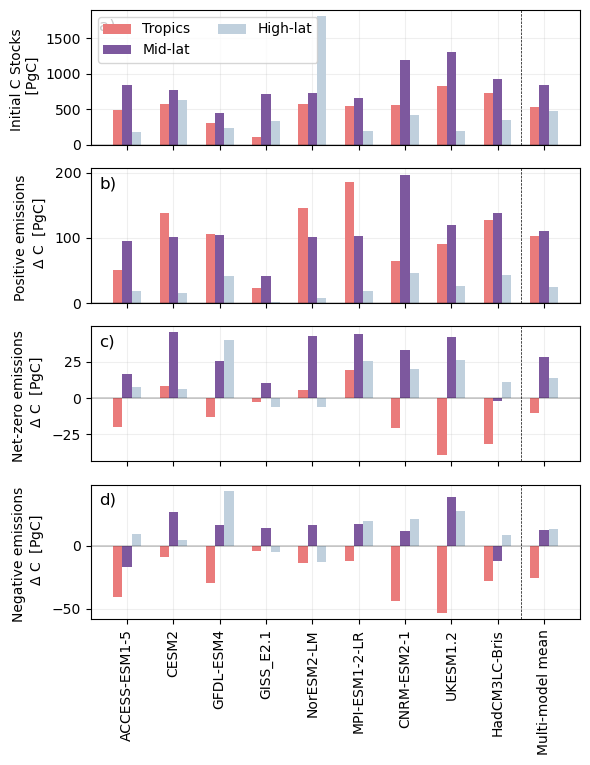

In [ ]:


#---- make grouped not stacked

# 

labels= ['Tropics','Mid-lat','High-lat']
# column_names=["Total C [PgC]", "Highlat C [PgC]", "Midlat C [PgC]", "Lowlat C [PgC]"]
group_names = ["Initial Carbon Content","Delta after Emissions Phase", "Following Net-Zero Emissions", "At Cumulative Zero Emissions"]
# g=0
lat_components = [ 'Lowlat C [PgC]', 'Midlat C [PgC]', 'Highlat C [PgC]'] #['Total C [PgC]', 'Lowlat C [PgC]', 'Midlat C [PgC]', 'Highlat C [PgC]']
n_lat=len(lat_components)

bar_width=0.2

#axes=axes.flatten()


hatchlist=['','o','xx','']#'//']
alphalist=[1,0.3,0.5,.8]
latcolors=pinkpurpleblue


df=veg_stock_delta_cTot
fig, axes = plt.subplots(4,1,figsize=(6, 8))

for g in range(len(group_names)):
    for m in range(len(modellist)):
        model=modellist[m]
        mcolor=modelcolors[m]
    
        for l in range(n_lat):

            colname = lat_components[l]
            value = df.loc[(df.index == model) & (df['Group'] == group_names[g]), colname].values[0]
    
            # Compute x-position: shift each lat component by bar_width
            xpos = m + (l - n_lat / 2) * bar_width + bar_width / 2
    
            axes[g].bar(xpos,
                        value,
                        width=bar_width,
                        #hatch=hatchlist[l],
                        #color=mcolor, #if l != 0 else 'white',  # white for Total, color for others
                        color=latcolors[l],
                        #edgecolor=mcolor,
                        #alpha=alphalist[l],
                        label=f'{labels[l]}' if g == 0 and m==0 else None ,#label=f'{model}_{colname}' if g == 0 else None  # only label in first group
                        )
            
    # add model mean column
    for l in range(n_lat):
        m = len(modellist)

        colname = lat_components[l]
        value = np.nanmean(df.loc[(df['Group'] == group_names[g]), colname].values[:-1])   # model mean

        # Compute x-position: shift each lat component by bar_width
        xpos = m + (l - n_lat / 2) * bar_width + bar_width / 2

        axes[g].bar(xpos,
                    value,
                    width=bar_width,
                    color=latcolors[l],
                    )

    
    axes[g].set_axisbelow(True)
    axes[g].grid(alpha=0.2)
    axes[g].annotate(subplotlabelnames[g],
                     xy=(0, 1), xycoords='axes fraction',
                     xytext=(+0.5, -0.5), textcoords='offset fontsize',
                     fontsize='large', verticalalignment='top')
    axes[g].axvline(len(modellist)-0.5, color="black", lw=0.5, linestyle="--")
    axes[g].axhline(0, color="black", lw=0.5)

    # Only show x-axis ticks on the last subplot
    if g == len(group_names) - 1:
        axes[g].set_xticks(np.arange(len(modellist)+1))
        axes[g].set_xticklabels(np.append(modellist,"Multi-model mean"), rotation=90)
    else:
        axes[g].set_xticks(np.arange(len(modellist)+1))
        axes[g].tick_params(labelbottom=False)


axes[0].set_ylabel('Initial C Stocks \n [PgC]')
axes[1].set_ylabel('Positive emissions \n $\Delta$ C  [PgC]')
axes[2].set_ylabel('Net-zero emissions \n $\Delta$ C  [PgC]')
axes[3].set_ylabel('Negative emissions \n $\Delta$ C  [PgC]')

axes[0].legend(ncol=2)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
#fig.suptitle("Carbon and $\Delta$ Carbon by Latitude", fontsize=12)#,ha='center')






# plt.show()
plt.savefig("figures/bar_latchange_PgC.pdf", bbox_inches='tight')
plt.savefig("figures/bar_latchange_PgC.png", bbox_inches='tight')
plt.show()
plt.close()

<>:154: SyntaxWarning: invalid escape sequence '\D'
<>:155: SyntaxWarning: invalid escape sequence '\D'
<>:156: SyntaxWarning: invalid escape sequence '\D'
<>:154: SyntaxWarning: invalid escape sequence '\D'
<>:155: SyntaxWarning: invalid escape sequence '\D'
<>:156: SyntaxWarning: invalid escape sequence '\D'
/var/folders/mt/vkb75n9d7kx45p7qhp1fc52r0000gn/T/ipykernel_96518/39931499.py:154: SyntaxWarning: invalid escape sequence '\D'
  axes[1].set_ylabel('Positive emissions \n $\Delta$ C  [PgC]')
/var/folders/mt/vkb75n9d7kx45p7qhp1fc52r0000gn/T/ipykernel_96518/39931499.py:155: SyntaxWarning: invalid escape sequence '\D'
  axes[2].set_ylabel('Net-zero emissions \n $\Delta$ C  [PgC]')
/var/folders/mt/vkb75n9d7kx45p7qhp1fc52r0000gn/T/ipykernel_96518/39931499.py:156: SyntaxWarning: invalid escape sequence '\D'
  axes[3].set_ylabel('Negative emissions \n $\Delta$ C  [PgC]')


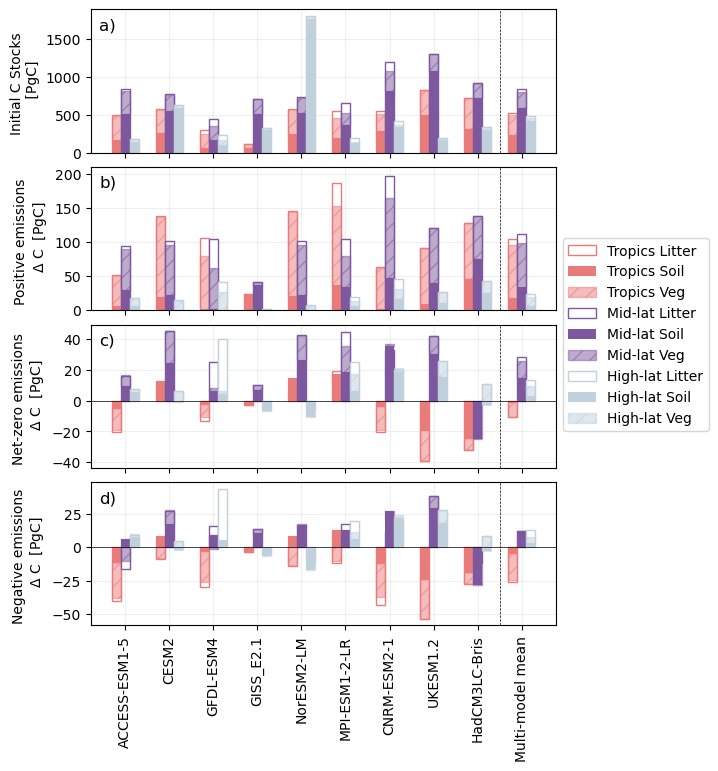

In [124]:


#---- make grouped *and* stacked
# bar graph of % veg % soil
# 

labels= ['Tropics','Mid-lat','High-lat']
# column_names=["Total C [PgC]", "Highlat C [PgC]", "Midlat C [PgC]", "Lowlat C [PgC]"]
group_names = ["Initial Carbon Content","Delta after Emissions Phase", "Following Net-Zero Emissions", "At Cumulative Zero Emissions"]
# g=0
lat_components = [ 'Lowlat C [PgC]', 'Midlat C [PgC]', 'Highlat C [PgC]'] #['Total C [PgC]', 'Lowlat C [PgC]', 'Midlat C [PgC]', 'Highlat C [PgC]']
n_lat=len(lat_components)
dflist=[veg_stock_delta_troplat, veg_stock_delta_midlat, veg_stock_delta_highlat]

bar_width=0.2

#axes=axes.flatten()


hatchlist=['','o','xx','']#'//']
alphalist=[1,0.3,0.5,.8]
 # latcolors=['#94E86B','#6B74E8','#E8906B']
latcolors=['#E8B46B','#6BE0E8','#6B91E8']
# latcolors=['#FE7180','#FFFA70','#70CFFF']
latcolors=['#EA7B7B','#7D589E','#C0D0DD']


df=veg_stock_delta_cTot
fig, axes = plt.subplots(4,1,figsize=(6, 8))

for g in range(len(group_names)):
    for m in range(len(modellist)):
        model=modellist[m]
        mcolor=modelcolors[m]
    
        for l in range(n_lat):

            colname = lat_components[l]
            df=veg_stock_delta_cTot
            totalC = df.loc[(df.index == model) & (df['Group'] == group_names[g]), colname].values[0]

            df=dflist[l]
            totalC = df.loc[(df.index == model) & (df['Group'] == group_names[g]), 'Total C [PgC]'].values[0] # this gives latitidue range total C
            soilC=totalC*(1/100)*df.loc[(df.index == model) & (df['Group'] == group_names[g]), '% Soil'].values[0]
            vegC=totalC*(1/100)*df.loc[(df.index == model) & (df['Group'] == group_names[g]), '% Vegetation'].values[0]
            # Compute x-position: shift each lat component by bar_width
            xpos = m + (l - n_lat / 2) * bar_width + bar_width / 2
    
            axes[g].bar(xpos,
                        totalC,
                        width=bar_width,
                        #hatch=hatchlist[l],
                        color='white', #mcolor, #if l != 0 else 'white',  # white for Total, color for others
                        # color=latcolors[l],
                        edgecolor=latcolors[l], #mcolor,
                        #alpha=alphalist[l],
                        label= f'{labels[l]}' +' Litter' if  m==0 else None  ,#label=f'{model}_{colname}' if g == 0 else None  # only label in first group
                        )

            axes[g].bar(xpos,
                        soilC,
                        width=bar_width,
                        #hatch=hatchlist[l],
                        #color=mcolor, #if l != 0 else 'white',  # white for Total, color for others
                        color=latcolors[l],
                        #edgecolor=mcolor,
                        #alpha=alphalist[l],
                        label=f'{labels[l]}' +' Soil' if m==0 else None ,#label=f'{model}_{colname}' if g == 0 else None  # only label in first group
                        )
            axes[g].bar(xpos,
                        vegC,
                        bottom=soilC,
                        width=bar_width,
                        hatch='//',
                        #color=mcolor, #if l != 0 else 'white',  # white for Total, color for others
                        color=latcolors[l],
                        edgecolor=latcolors[l],
                        alpha=0.5,
                        label= f'{labels[l]}' +' Veg' if m==0 else None  ,#label=f'{model}_{colname}' if g == 0 else None  # only label in first group
                        )
        
    # add model mean column
    for l in range(n_lat):
        m = len(modellist)

        colname = lat_components[l]
        df=veg_stock_delta_cTot
        totalC = np.nanmean(df.loc[(df['Group'] == group_names[g]), colname].values[:-2])

        df=dflist[l]
        
        totalC = df.loc[(df['Group'] == group_names[g]), 'Total C [PgC]'].values[:-2] # this gives latitidue range total C
        totalC_mean = np.nanmean(totalC)
        soilC=np.nanmean(totalC*(1/100)*(df.loc[(df['Group'] == group_names[g]), '% Soil'].values[:-2]))
        vegC=np.nanmean(totalC*(1/100)*(df.loc[(df['Group'] == group_names[g]), '% Vegetation'].values[:-2]))
        # Compute x-position: shift each lat component by bar_width
        xpos = m + (l - n_lat / 2) * bar_width + bar_width / 2

        axes[g].bar(xpos,
                    totalC_mean,
                    width=bar_width,
                    #hatch=hatchlist[l],
                    color='white', #mcolor, #if l != 0 else 'white',  # white for Total, color for others
                    # color=latcolors[l],
                    edgecolor=latcolors[l], #mcolor,
                    #alpha=alphalist[l],
                    label= f'{labels[l]}' +' Litter' if  m==0 else None  ,#label=f'{model}_{colname}' if g == 0 else None  # only label in first group
                    )

        axes[g].bar(xpos,
                    soilC,
                    width=bar_width,
                    #hatch=hatchlist[l],
                    #color=mcolor, #if l != 0 else 'white',  # white for Total, color for others
                    color=latcolors[l],
                    #edgecolor=mcolor,
                    #alpha=alphalist[l],
                    label=f'{labels[l]}' +' Soil' if m==0 else None ,#label=f'{model}_{colname}' if g == 0 else None  # only label in first group
                    )
        axes[g].bar(xpos,
                    vegC,
                    bottom=soilC,
                    width=bar_width,
                    hatch='//',
                    #color=mcolor, #if l != 0 else 'white',  # white for Total, color for others
                    color=latcolors[l],
                    edgecolor=latcolors[l],
                    alpha=0.5,
                    label= f'{labels[l]}' +' Veg' if m==0 else None  ,#label=f'{model}_{colname}' if g == 0 else None  # only label in first group
                    )


    
    axes[g].set_axisbelow(True)
    axes[g].grid(alpha=0.2)
    axes[g].axvline(len(modellist)-0.5, color="black", lw=0.5, linestyle="--")
    axes[g].axhline(0, color="black", lw=0.5)

    # fix panel b y-axis limits
    if g == 1: axes[g].set_ylim(0,210)

    # Only show x-axis ticks on the last subplot
    if g == len(group_names) - 1:
        axes[g].set_xticks(np.arange(len(modellist)+1))
        axes[g].set_xticklabels(np.append(modellist,"Multi-model mean"), rotation=90)
    else:
        axes[g].set_xticks(np.arange(len(modellist)+1))
        axes[g].tick_params(labelbottom=False)

    axes[g].annotate(subplotlabelnames[g],
                     xy=(0, 1), xycoords='axes fraction',
                     xytext=(+0.5, -0.5), textcoords='offset fontsize',
                     fontsize='large', verticalalignment='top')

axes[0].set_ylabel('Initial C Stocks \n [PgC]')
axes[1].set_ylabel('Positive emissions \n $\Delta$ C  [PgC]')
axes[2].set_ylabel('Net-zero emissions \n $\Delta$ C  [PgC]')
axes[3].set_ylabel('Negative emissions \n $\Delta$ C  [PgC]')

# axes[0].legend(ncol=3)
axes[0].legend(loc='upper left', ncol=1,bbox_to_anchor=(1, -0.55))#fontsize=6)
# fig.tight_layout()
# fig.subplots_adjust(top=0.9)
plt.subplots_adjust(hspace=0.1)
#fig.suptitle("Land carbon and $\Delta$ Carbon by latitude", fontsize=12, y=0.91)#,ha='center')






# plt.show()
plt.savefig("figures/bar_latchange_bypool_PgC.pdf", bbox_inches='tight')
plt.savefig("figures/bar_latchange_bypool_PgC.png", bbox_inches='tight')
plt.show()
plt.close()

### by carbon pool

<>:103: SyntaxWarning: invalid escape sequence '\D'
<>:104: SyntaxWarning: invalid escape sequence '\D'
<>:105: SyntaxWarning: invalid escape sequence '\D'
<>:103: SyntaxWarning: invalid escape sequence '\D'
<>:104: SyntaxWarning: invalid escape sequence '\D'
<>:105: SyntaxWarning: invalid escape sequence '\D'
/var/folders/mt/vkb75n9d7kx45p7qhp1fc52r0000gn/T/ipykernel_96518/2129274494.py:103: SyntaxWarning: invalid escape sequence '\D'
  axes[1].set_ylabel('Positive emissions \n $\Delta$ C  [PgC]')
/var/folders/mt/vkb75n9d7kx45p7qhp1fc52r0000gn/T/ipykernel_96518/2129274494.py:104: SyntaxWarning: invalid escape sequence '\D'
  axes[2].set_ylabel('Net-zero emissions \n $\Delta$ C  [PgC]')
/var/folders/mt/vkb75n9d7kx45p7qhp1fc52r0000gn/T/ipykernel_96518/2129274494.py:105: SyntaxWarning: invalid escape sequence '\D'
  axes[3].set_ylabel('Negative emissions \n $\Delta$ C  [PgC]')


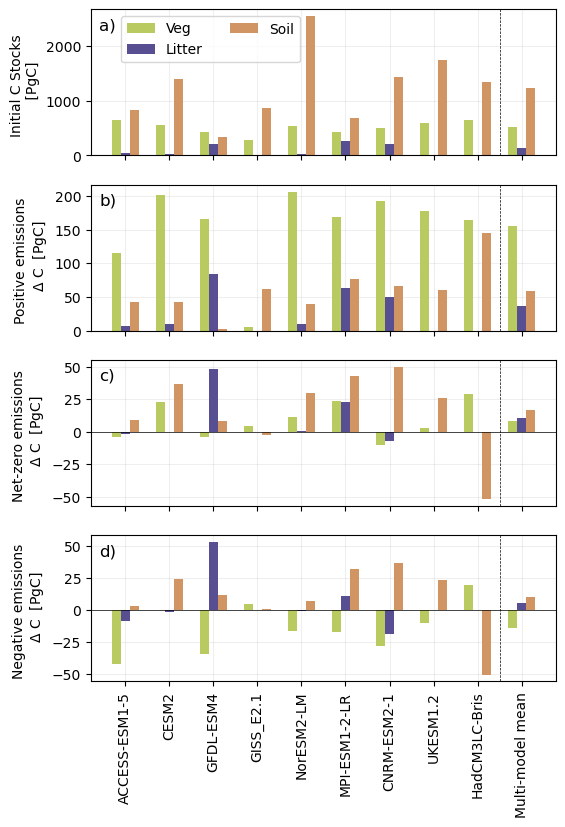

In [141]:


#---- make grouped not stacked, but for veg, soil, litter, total
# bar graph of % veg % soil
# 

column_names=["Total C [PgC]", "% Vegetation", "% Litter", "% Soil"]
plot_cols=["% Vegetation", "% Litter", "% Soil"]
labels=["Veg", "Litter", "Soil"]
group_names = ["Initial Carbon Content","Delta after Emissions Phase", "Following Net-Zero Emissions", "At Cumulative Zero Emissions"]
# g=0

    # if l==0:
    #     veg_stock_delta_global=veg_stock_delta
    # elif l==1:
    #     veg_stock_delta_highlat=veg_stock_delta
    # elif l==2:
    #     veg_stock_delta_midlat=veg_stock_delta
    # else:
    #     veg_stock_delta_troplat=veg_stock_delta


bar_width=0.2

#axes=axes.flatten()


hatchlist=['','o','xx','']#'//']
alphalist=[1,0.3,0.5,.8]

latcolors=greenpurplebrown

df=veg_stock_delta_global
fig, axes = plt.subplots(4,1,figsize=(6, 8))

for g in range(len(group_names)):
    for m in range(len(modellist)):
        model=modellist[m]
        mcolor=modelcolors[m]

        totalC= df.loc[(df.index == model) & (df['Group'] == group_names[g]), "Total C [PgC]"].values[0]
        
        for c in range(len(plot_cols)):

            colname = plot_cols[c]
            valueC = df.loc[(df.index == model) & (df['Group'] == group_names[g]), colname].values[0]
            # if c==0:
            #     value = valueC
            # else:
            #     value = valueC*totalC/100
            value = valueC*totalC/100
    
            # Compute x-position: shift each lat component by bar_width
            xpos = m + (c - (len(column_names)-1) / 2) * bar_width + bar_width / 2
    
            axes[g].bar(xpos,
                        value,
                        width=bar_width,
                        #hatch=hatchlist[l],
                        #color=mcolor, #if l != 0 else 'white',  # white for Total, color for others
                        color=latcolors[c],
                        # edgecolor=latcolors[c],
                        #alpha=0.6,
                        label=f'{labels[c]}' if g == 0 and m==0 else None ,#label=f'{model}_{colname}' if g == 0 else None  # only label in first group
                        )

    # add model mean column
    totalC= df.loc[(df['Group'] == group_names[g]), "Total C [PgC]"].values[:-2]
    for c in range(len(plot_cols)):
        m = len(modellist)

        colname = plot_cols[c]
        valueC = df.loc[(df['Group'] == group_names[g]), colname].values[:-2]
        value = np.nanmean(valueC*totalC/100)

        # Compute x-position: shift each lat component by bar_width
        xpos = m + (c - (len(column_names)-1) / 2) * bar_width + bar_width / 2
        
        axes[g].bar(xpos,
                    value,
                    width=bar_width,
                    color=latcolors[c],
                    )

    
    axes[g].set_axisbelow(True)
    axes[g].grid(alpha=0.2)
    axes[g].axvline(len(modellist)-0.5, color="black", lw=0.5, linestyle="--")
    axes[g].axhline(0, color="black", lw=0.5)

    axes[g].annotate(subplotlabelnames[g],
                     xy=(0, 1), xycoords='axes fraction',
                     xytext=(+0.5, -0.5), textcoords='offset fontsize',
                     fontsize='large', verticalalignment='top')

    # Only show x-axis ticks on the last subplot
    if g == len(group_names) - 1:
        axes[g].set_xticks(np.arange(len(modellist)+1))
        axes[g].set_xticklabels(np.append(modellist,"Multi-model mean"), rotation=90)
    else:
        axes[g].set_xticks(np.arange(len(modellist)+1))
        axes[g].tick_params(labelbottom=False)

axes[0].set_ylabel('Initial C Stocks \n [PgC]')
axes[1].set_ylabel('Positive emissions \n $\Delta$ C  [PgC]')
axes[2].set_ylabel('Net-zero emissions \n $\Delta$ C  [PgC]')
axes[3].set_ylabel('Negative emissions \n $\Delta$ C  [PgC]')

axes[0].legend(ncol=2,loc='upper left',bbox_to_anchor=[0.05,1])
# fig.tight_layout()
fig.subplots_adjust(top=0.95)
#fig.suptitle("Carbon and $\Delta$ Carbon by Pool", fontsize=12)#,ha='center')







plt.savefig("figures/bar_poolchange_PgC.pdf", bbox_inches='tight')
plt.savefig("figures/bar_poolchange_PgC.png", bbox_inches='tight')
plt.show()
plt.close()

# Time series

<>:95: SyntaxWarning: invalid escape sequence '\D'
<>:96: SyntaxWarning: invalid escape sequence '\D'
<>:97: SyntaxWarning: invalid escape sequence '\D'
<>:98: SyntaxWarning: invalid escape sequence '\D'
<>:99: SyntaxWarning: invalid escape sequence '\D'
<>:95: SyntaxWarning: invalid escape sequence '\D'
<>:96: SyntaxWarning: invalid escape sequence '\D'
<>:97: SyntaxWarning: invalid escape sequence '\D'
<>:98: SyntaxWarning: invalid escape sequence '\D'
<>:99: SyntaxWarning: invalid escape sequence '\D'
/var/folders/mt/vkb75n9d7kx45p7qhp1fc52r0000gn/T/ipykernel_96518/399822517.py:95: SyntaxWarning: invalid escape sequence '\D'
  axes[0,0].set_ylabel('$\Delta$ Total C [PgC]',fontsize=12)
/var/folders/mt/vkb75n9d7kx45p7qhp1fc52r0000gn/T/ipykernel_96518/399822517.py:96: SyntaxWarning: invalid escape sequence '\D'
  axes[1,0].set_ylabel('$\Delta$ Soil [PgC]',fontsize=12)
/var/folders/mt/vkb75n9d7kx45p7qhp1fc52r0000gn/T/ipykernel_96518/399822517.py:97: SyntaxWarning: invalid escape sequenc

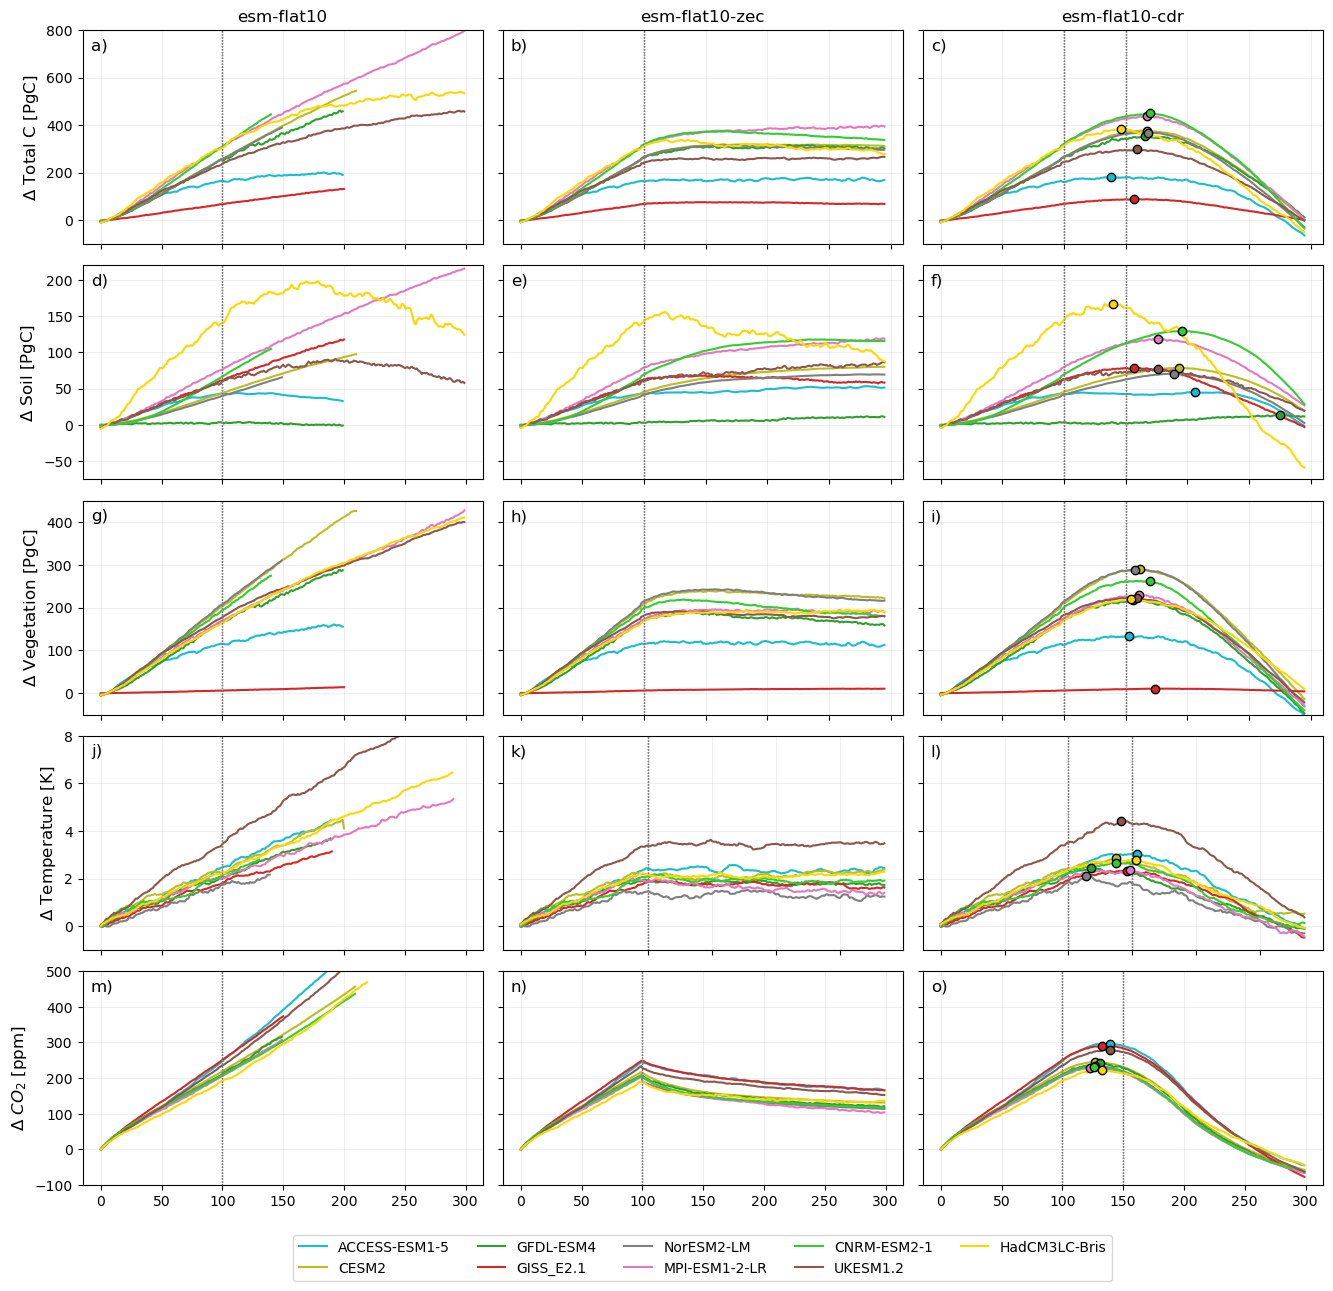

In [169]:
# normalized by initial carbon content, and continuous time series
N=11
nr=5
nc=3
fig, axes = plt.subplots(nr,nc,figsize=(16, 3*nr))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change

l=0
varlisthere=['cTot', 'cSoil', 'cVeg','tas']

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(varlisthere)):
        var=varlisthere[vi]
        e=0
        timeseriesE=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=var, latrange=latlist[l])
        initC=timeseriesE.data[1:10].mean()

        e=1
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=var, latrange=latlist[l])

        # flat10
        Cts=timeseriesE.data.values
        Cts=Cts[np.where(Cts>0)]- initC.values
        if varlisthere[vi]=='tas':
            Cts=np.convolve(Cts, np.ones(N)/N, mode='valid')

        axes[vi,0].plot(Cts[0:300],label=model,color=mcolor)
        axes[vi,0].grid(alpha=0.2)
        axes[vi,0].axvline(100,lw=0.8,color="gray",linestyle=":")

        #flat10 zec
        Cts=np.append(timeseriesE.data[1:99].values, timeseries.data[1:199].values) - initC.values
        if varlisthere[vi]=='tas':
            Cts=np.convolve(Cts, np.ones(N)/N, mode='valid')
            
        axes[vi,1].plot(Cts,label=model,color=mcolor)
        axes[vi,1].grid(alpha=0.2)
        axes[vi,1].axvline(100,lw=0.8,color="gray",linestyle=":")

        e=2
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=var, latrange=latlist[l])

        # flat10 cdr
        Cts=np.append(timeseriesE.data[1:99].values, timeseries.data[1:199].values) - initC.values
        
        if varlisthere[vi]=='tas':
            Cts=np.convolve(Cts, np.ones(N)/N, mode='valid')
            
        #Cts=timeseries.data[1:199]-initC
        axes[vi,2].plot(Cts,label=model,color=mcolor)
        axes[vi,2].grid(alpha=0.2)
        axes[vi,2].axvline(100,lw=0.8,color="gray",linestyle=":")
        axes[vi,2].axvline(150,lw=0.8,color="gray",linestyle=":")

        # add dot at maximum value    
        if np.isfinite(np.max(Cts)):
            axes[vi,2].scatter(np.where(Cts==np.max(Cts)),np.max(Cts),color=mcolor,edgecolor="black", zorder=4)
        # np.argwhere(Cts==np.max(Cts))[0]
        # np.where(Cts==np.max(Cts))

    # plot CO2
    vi=vi+1 
    Cts= co2_flat10[model]-co2_flat10[model][0] 
    axes[vi,0].plot(Cts[0:300],label=model,color=mcolor)
    axes[vi,0].grid(alpha=0.2)
    axes[vi,0].axvline(100,lw=0.8,color="gray",linestyle=":")

    Cts= co2_flat10_zec[model]-co2_flat10_zec[model][0] 
    axes[vi,1].plot(Cts[0:300],label=model,color=mcolor)
    axes[vi,1].grid(alpha=0.2)
    axes[vi,1].axvline(100,lw=0.8,color="gray",linestyle=":")

    Cts= co2_flat10_cdr[model]-co2_flat10_cdr[model][0] 
    axes[vi,2].plot(Cts[0:300],label=model,color=mcolor)
    axes[vi,2].grid(alpha=0.2)
    axes[vi,2].axvline(100,lw=0.8,color="gray",linestyle=":")
    axes[vi,2].axvline(150,lw=0.8,color="gray",linestyle=":")
    # add dot at maximum value    
    if np.isfinite(np.max(Cts)):
        axes[vi,2].scatter(np.where(Cts==np.max(Cts)),np.max(Cts),color=mcolor,edgecolor="black", zorder=4)

axes[0,0].set_title('esm-flat10')
axes[0,1].set_title('esm-flat10-zec')
axes[0,2].set_title('esm-flat10-cdr')

axes[0,0].set_ylabel('$\Delta$ Total C [PgC]',fontsize=12)
axes[1,0].set_ylabel('$\Delta$ Soil [PgC]',fontsize=12)
axes[2,0].set_ylabel('$\Delta$ Vegetation [PgC]',fontsize=12)
axes[3,0].set_ylabel('$\Delta$ Temperature [K]',fontsize=12)
axes[4,0].set_ylabel('$\Delta$ $CO_2$ [ppm]',fontsize=12)

for air in range(nr):
    for aic in range(nc):
        axes[2,aic].set_xlabel('Year',fontsize=12)
    
        # axes[ai,0].set_ylabel('$\Delta$ ' +varlisthere[ai] +' [PgC]')
        
        # ylimits
        axes[0,aic].set_ylim([-100,800])
        axes[1,aic].set_ylim([-75,220])
        axes[2,aic].set_ylim([-50,450])
        axes[3,aic].set_ylim([-1,8])
        axes[4,aic].set_ylim([-100,500])#set_ylim([200,800])
    
        axes[air,1].yaxis.set_tick_params(labelcolor='none')
        axes[air,2].yaxis.set_tick_params(labelcolor='none')

        if air<nr-1:
            axes[air,aic].xaxis.set_tick_params(labelcolor='none')
    
        axes[air,aic].annotate(subplotlabelnames[(air+aic)+air*(nc-1)],
                     xy=(0, 1), xycoords='axes fraction',
                     xytext=(+0.5, -0.5), textcoords='offset fontsize',
                     fontsize='large', verticalalignment='top')

axes[4,1].legend(loc='upper center', ncol=5,bbox_to_anchor=(.5, -0.2))#fontsize=6)

plt.subplots_adjust(wspace=0.05, hspace=0.1)


plt.savefig("figures/CtimeseriesDelta_contiuous_allexp_" +latlist[l] +"_PgC_plusT.pdf", bbox_inches='tight')
plt.savefig("figures/CtimeseriesDelta_contiuous_allexp_" +latlist[l] +"_PgC_plusT.png", bbox_inches='tight')
plt.show()
plt.close()


<>:73: SyntaxWarning: invalid escape sequence '\D'
<>:74: SyntaxWarning: invalid escape sequence '\D'
<>:75: SyntaxWarning: invalid escape sequence '\D'
<>:73: SyntaxWarning: invalid escape sequence '\D'
<>:74: SyntaxWarning: invalid escape sequence '\D'
<>:75: SyntaxWarning: invalid escape sequence '\D'
/var/folders/mt/vkb75n9d7kx45p7qhp1fc52r0000gn/T/ipykernel_96518/92377629.py:73: SyntaxWarning: invalid escape sequence '\D'
  axes[0,0].set_ylabel('$\Delta$ Total C [PgC]',fontsize=12)
/var/folders/mt/vkb75n9d7kx45p7qhp1fc52r0000gn/T/ipykernel_96518/92377629.py:74: SyntaxWarning: invalid escape sequence '\D'
  axes[1,0].set_ylabel('$\Delta$ Soil [PgC]',fontsize=12)
/var/folders/mt/vkb75n9d7kx45p7qhp1fc52r0000gn/T/ipykernel_96518/92377629.py:75: SyntaxWarning: invalid escape sequence '\D'
  axes[2,0].set_ylabel('$\Delta$ Vegetation [PgC]',fontsize=12)


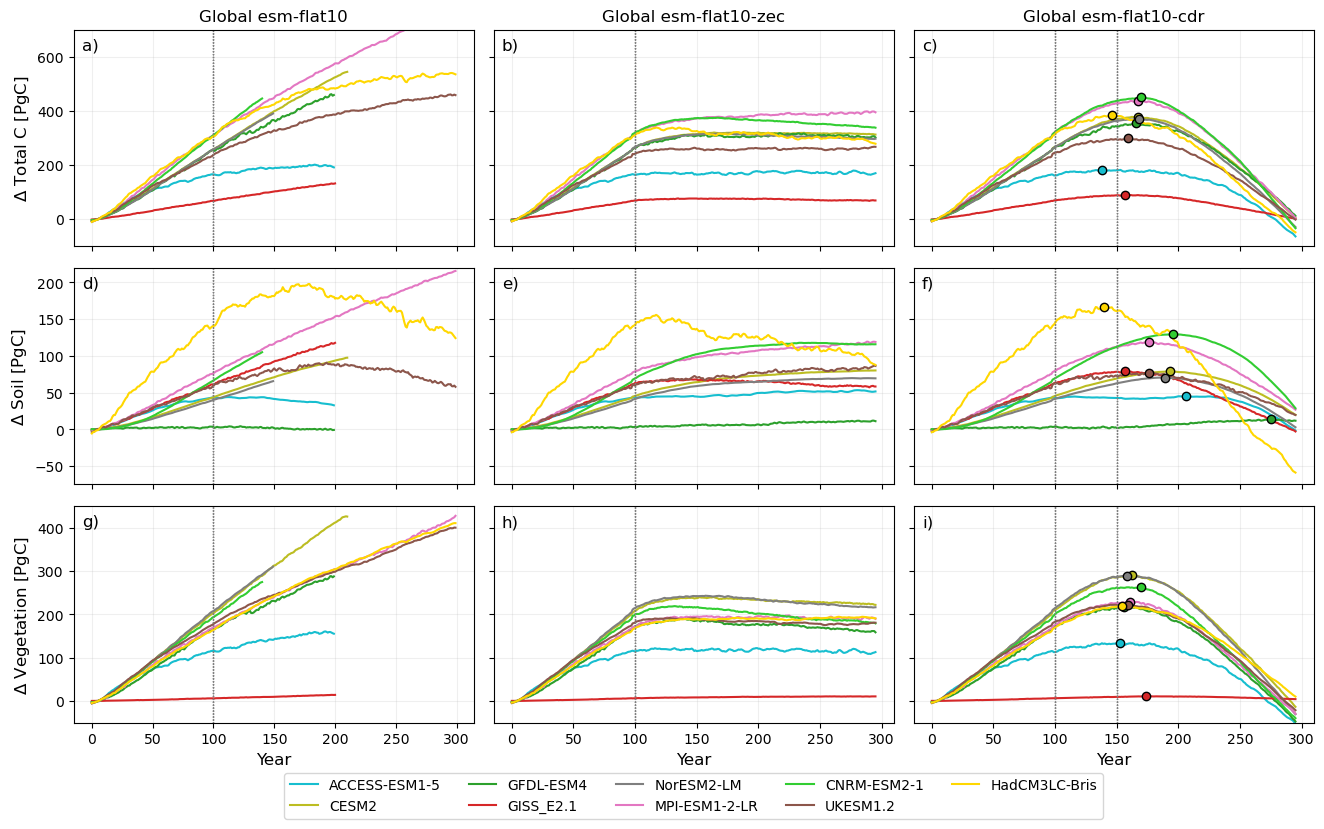

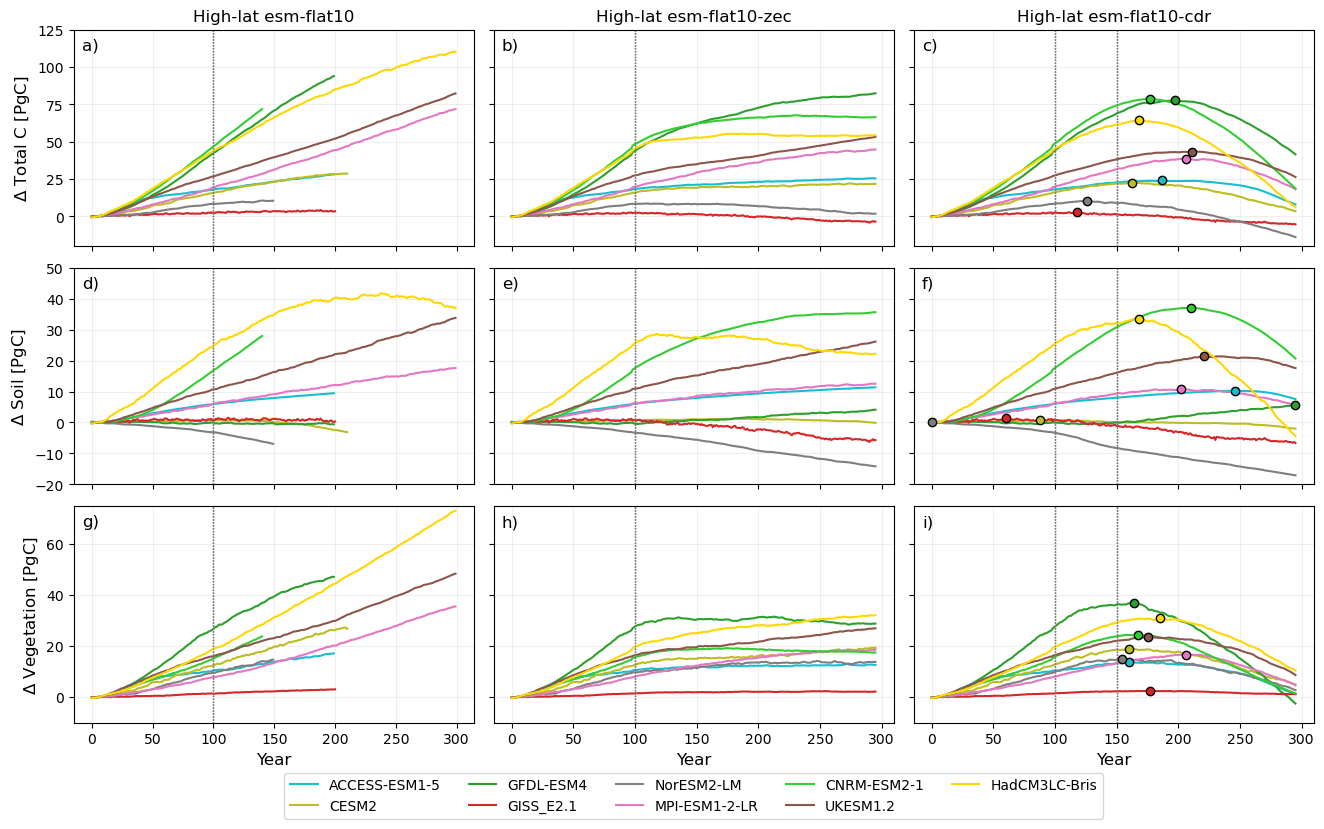

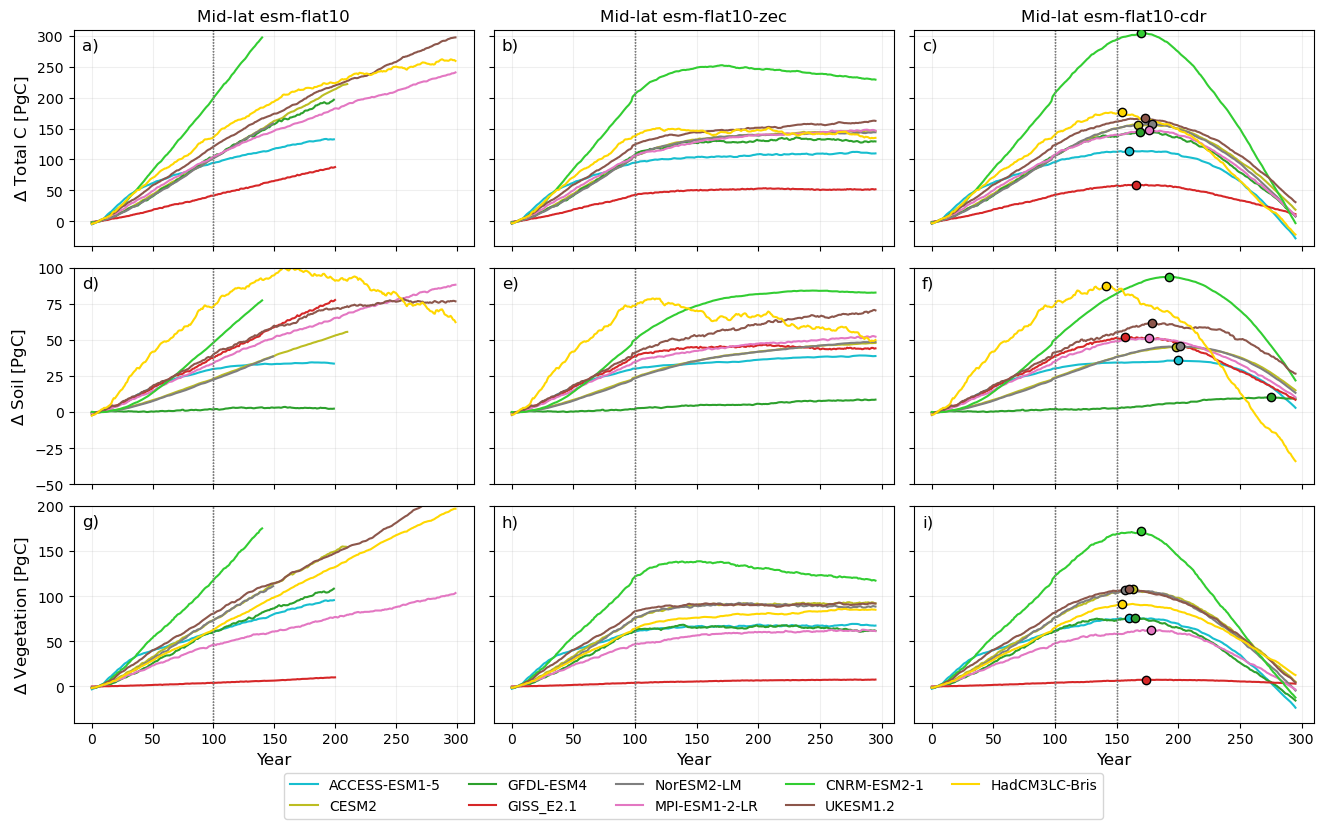

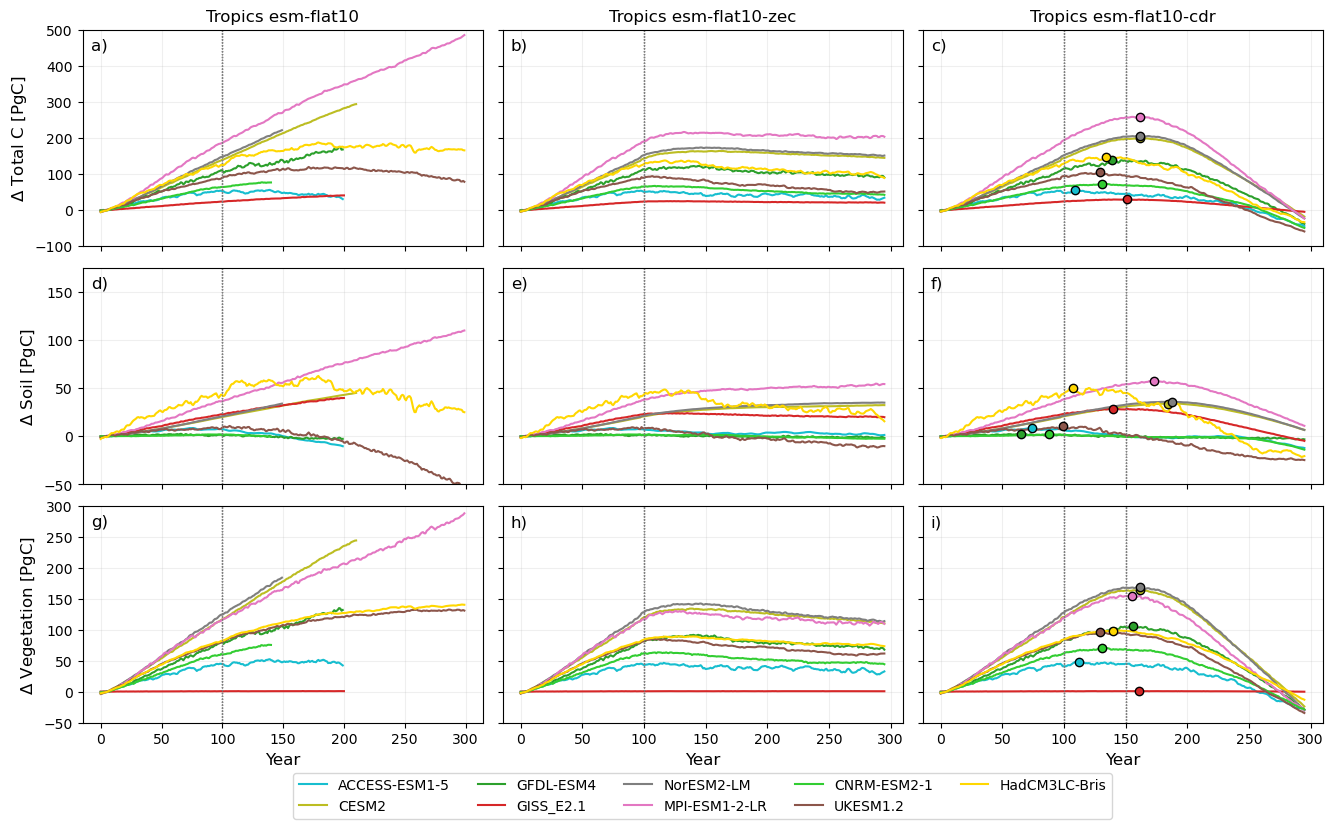

In [170]:
# normalized by initial carbon content, and continuous time series
ymax=[[700, 220, 450],[125, 50, 75],[310, 100, 200],[500, 175, 300]]
ymin=[[-100, -75, -50],[-20, -20, -10],[-40, -50, -40],[-100, -50, -50]]

latlistname=['Global','High-lat','Mid-lat','Tropics']
for l in range(len(latlist)):
    nr=3
    nc=3
    fig, axes = plt.subplots(nr,nc,figsize=(16, 9))
    #axes=axes.flatten()
    
    # rows are carbon variables, cTot, cVeg, cSoil
    # columns are total change, % change
    
    # l=0
    varlisthere=['cTot', 'cSoil', 'cVeg']
    
    for m in range(len(modellist)):
        model=modellist[m]
        mcolor=modelcolors[m]
    
        for vi in range(len(varlisthere)):
            var=varlisthere[vi]
            e=0
            timeseriesE=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=var, latrange=latlist[l])
            initC=timeseriesE.data[1:10].mean()
    
            e=1
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=var, latrange=latlist[l])
    
            # flat10
            Cts=timeseriesE.data.values
            Cts=Cts[np.where(Cts>0)]- initC.values
    
            axes[vi,0].plot(Cts[0:300],label=model,color=mcolor)
            axes[vi,0].grid(alpha=0.2)
            axes[vi,0].axvline(100,lw=0.8,color="gray",linestyle=":")
    
            #flat10 zec
            Cts=np.append(timeseriesE.data[1:99].values, timeseries.data[1:199].values) - initC.values
    
            axes[vi,1].plot(Cts,label=model,color=mcolor)
            axes[vi,1].grid(alpha=0.2)
            axes[vi,1].axvline(100,lw=0.8,color="gray",linestyle=":")
    
            e=2
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=var, latrange=latlist[l])
    
            # flat10 cdr
            Cts=np.append(timeseriesE.data[1:99].values, timeseries.data[1:199].values) - initC.values
            
            
            #Cts=timeseries.data[1:199]-initC
            axes[vi,2].plot(Cts,label=model,color=mcolor)
            axes[vi,2].grid(alpha=0.2)
            axes[vi,2].axvline(100,lw=0.8,color="gray",linestyle=":")
            axes[vi,2].axvline(150,lw=0.8,color="gray",linestyle=":")
    
            # add dot at maximum value    
            if np.isfinite(np.max(Cts)):
                axes[vi,2].scatter(np.where(Cts==np.max(Cts)),np.max(Cts),color=mcolor,edgecolor="black", zorder=4)
            # np.argwhere(Cts==np.max(Cts))[0]
            # np.where(Cts==np.max(Cts))
    
    
    axes[0,0].set_title(latlistname[l] +' esm-flat10')
    axes[0,1].set_title(latlistname[l] +' esm-flat10-zec')
    axes[0,2].set_title(latlistname[l] +' esm-flat10-cdr')
    
    axes[0,0].set_ylabel('$\Delta$ Total C [PgC]',fontsize=12)
    axes[1,0].set_ylabel('$\Delta$ Soil [PgC]',fontsize=12)
    axes[2,0].set_ylabel('$\Delta$ Vegetation [PgC]',fontsize=12)
    
    for air in range(nr):
        for aic in range(nc):
            axes[2,aic].set_xlabel('Year',fontsize=12)
        
            # axes[ai,0].set_ylabel('$\Delta$ ' +varlisthere[ai] +' [PgC]')
            
            # ylimits
            axes[air,aic].set_ylim(ymin[l][air],ymax[l][air])
            # axes[0,aic].set_ylim([-100,800])
            # axes[1,aic].set_ylim([-75,220])
            # axes[2,aic].set_ylim([-50,450])
        
            axes[air,1].yaxis.set_tick_params(labelcolor='none')
            axes[air,2].yaxis.set_tick_params(labelcolor='none')
        
            axes[0,aic].xaxis.set_tick_params(labelcolor='none')
            axes[1,aic].xaxis.set_tick_params(labelcolor='none')
        
            axes[air,aic].annotate(subplotlabelnames[(air+aic)+air*(nc-1)],
                         xy=(0, 1), xycoords='axes fraction',
                         xytext=(+0.5, -0.5), textcoords='offset fontsize',
                         fontsize='large', verticalalignment='top')
    
    axes[2,1].legend(loc='upper center', ncol=5,bbox_to_anchor=(.5, -0.2))#fontsize=6)
    
    plt.subplots_adjust(wspace=0.05, hspace=0.1)
    
    
    plt.savefig("figures/CtimeseriesDelta_contiuous_allexp_" +latlist[l] +"_PgC.pdf", bbox_inches='tight')
    plt.savefig("figures/CtimeseriesDelta_contiuous_allexp_" +latlist[l] +"_PgC.png", bbox_inches='tight')
    plt.show()
    plt.close()

# Lead lag year

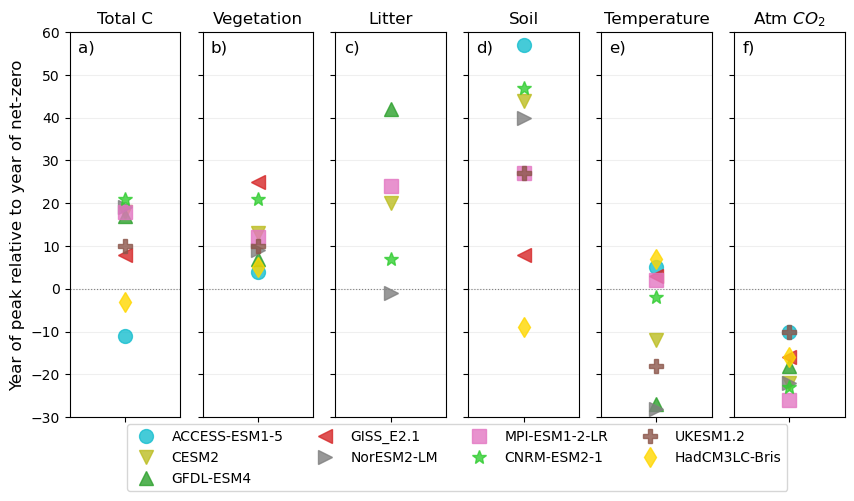

In [148]:
latrange='global'

leadlagpeak = leadlagpeak_global_cdr

fig, ax =plt.subplots(1,6,figsize=(10, 5))

for m in range(len(modellist)):
    model=modellist[m]
    
    ax[0].plot(1, leadlagpeak['cTot'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)
    ax[1].plot(1, leadlagpeak['cVeg'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)
    ax[2].plot(1, leadlagpeak['cLitter'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)
    ax[3].plot(1, leadlagpeak['cSoil'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)
    ax[4].plot(1, leadlagpeak['tas'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)
    ax[5].plot(1, leadlagpeak['co2'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)


ax[0].set_title('Total C')
ax[1].set_title('Vegetation')
ax[2].set_title('Litter')
ax[3].set_title('Soil')
ax[4].set_title('Temperature')
ax[5].set_title('Atm $CO_2$')

ax[0].set_ylabel('Year of peak relative to year of net-zero',fontsize=12)


for axi in range(6):
    ax[axi].yaxis.grid(alpha=0.2)
    ax[axi].axhline(0,lw=0.8,color="gray",linestyle=":")
    ymin=-30
    ymax=60
    ax[axi].set_ylim([ymin,ymax])
    ax[axi].yaxis.set_ticks(np.arange(ymin,ymax+1,10))
    ax[axi].xaxis.set_ticks([1])
    ax[axi].xaxis.set_tick_params(labelcolor='none')
    if axi>0:
        ax[axi].yaxis.set_tick_params(labelcolor='none')
    # else:
    #     ax[axi].yaxis.set_tick_params(fontsize=12)
        
    ax[axi].annotate(subplotlabelnames[axi],
                     xy=(0, 1), xycoords='axes fraction',
                     xytext=(+0.5, -0.5), textcoords='offset fontsize',
                     fontsize='large', verticalalignment='top')

# ax[5].legend()
lgax=ax[3].legend(loc='upper center', ncol=4,bbox_to_anchor=(-0.1, 0))


# fig.suptitle('year of peak relative to net zero - ' +latrange)

plt.savefig('figures/leadlagpeak_' +latrange +'.pdf', bbox_inches='tight')


# for label, ax in axs.items():
#     # Use Axes.annotate to put the label
#     # - at the top left corner (axes fraction (0, 1)),
#     # - offset half-a-fontsize right and half-a-fontsize down
#     #   (offset fontsize (+0.5, -0.5)),
#     # i.e. just inside the axes.
#     ax.annotate(
#         label,
#         xy=(0, 1), xycoords='axes fraction',
#         xytext=(+0.5, -0.5), textcoords='offset fontsize',
#         fontsize='medium', verticalalignment='top', fontfamily='serif',
#         bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

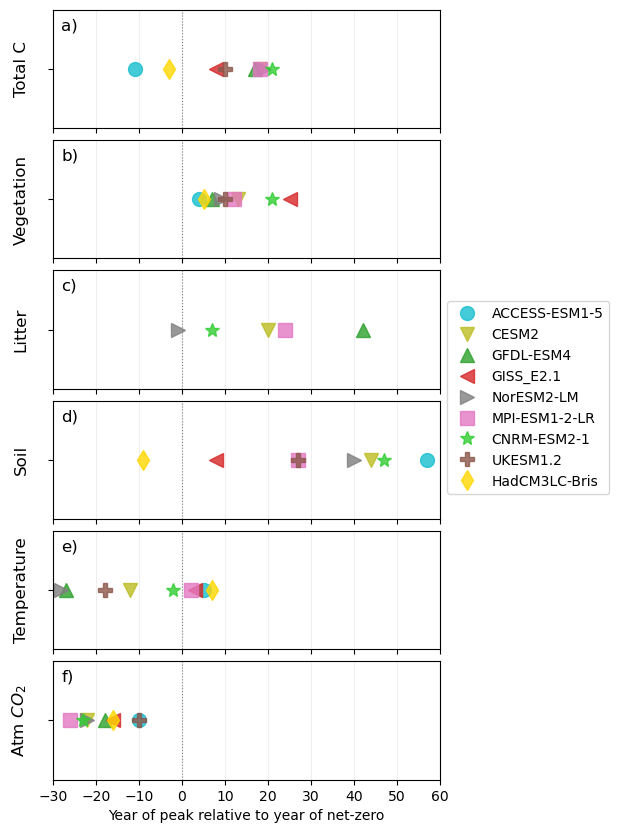

In [168]:
latrange='global'

leadlagpeak = leadlagpeak_global_cdr

nr=6
nc=1
fig, ax =plt.subplots(nr,nc,figsize=(5,10))

plotnames=['Total C', 'Vegetation', 'Litter', 'Soil', 'Temperature','Atm $CO_2$']

for m in range(len(modellist)):
    model=modellist[m]
    
    ax[0].plot(leadlagpeak['cTot'][model],1,color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)
    ax[1].plot(leadlagpeak['cVeg'][model],1,color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)
    ax[2].plot(leadlagpeak['cLitter'][model],1,color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)
    ax[3].plot(leadlagpeak['cSoil'][model],1,color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)
    ax[4].plot(leadlagpeak['tas'][model],1,color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)
    ax[5].plot(leadlagpeak['co2'][model],1,color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)


#ax[0].set_title('Year of peak relative to year of net-zero',fontsize=12)


for axi in range(6):
    ax[axi].set_ylabel(plotnames[axi],fontsize=12)
    ax[axi].xaxis.grid(alpha=0.2)
    ax[axi].axvline(0,lw=0.8,color="gray",linestyle=":")
    ymin=-30
    ymax=60
    ax[axi].set_xlim([ymin,ymax])
    ax[axi].xaxis.set_ticks(np.arange(ymin,ymax+1,10))
    ax[axi].yaxis.set_ticks([1])
    ax[axi].yaxis.set_tick_params(labelcolor='none')
    if axi<nr-1:
        ax[axi].xaxis.set_tick_params(labelcolor='none')
    # else:
    #     ax[axi].yaxis.set_tick_params(fontsize=12)
        
    ax[axi].annotate(subplotlabelnames[axi],
                     xy=(0, 1), xycoords='axes fraction',
                     xytext=(+0.5, -0.5), textcoords='offset fontsize',
                     fontsize='large', verticalalignment='top')

# ax[5].legend()
ax[2].legend(loc='upper left', ncol=1,bbox_to_anchor=(1, 0.8))
ax[nr-1].set_xlabel("Year of peak relative to year of net-zero")

fig.subplots_adjust(hspace=0.1)

# fig.suptitle('year of peak relative to net zero - ' +latrange)

plt.savefig('figures/leadlagpeak_sideways_' +latrange +'.pdf', bbox_inches='tight')
plt.show()
plt.close()

# for label, ax in axs.items():
#     # Use Axes.annotate to put the label
#     # - at the top left corner (axes fraction (0, 1)),
#     # - offset half-a-fontsize right and half-a-fontsize down
#     #   (offset fontsize (+0.5, -0.5)),
#     # i.e. just inside the axes.
#     ax.annotate(
#         label,
#         xy=(0, 1), xycoords='axes fraction',
#         xytext=(+0.5, -0.5), textcoords='offset fontsize',
#         fontsize='medium', verticalalignment='top', fontfamily='serif',
#         bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

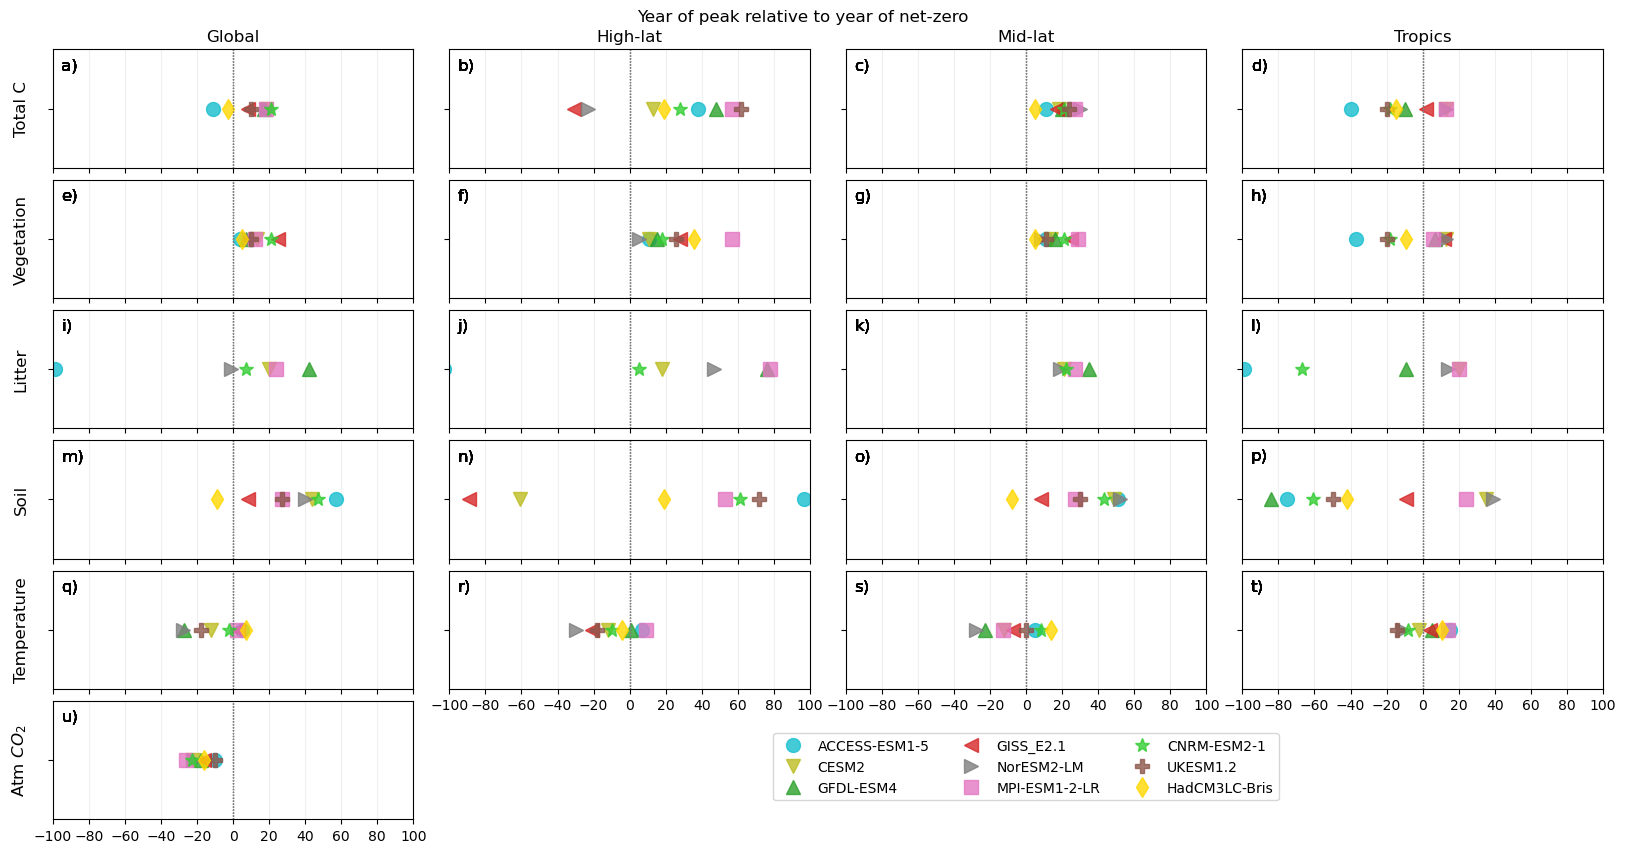

In [18]:
latrange='global'

# leadlagpeak = leadlagpeak_global_cdr
leadlaglist = [leadlagpeak_global_cdr,leadlagpeak_highlat_cdr,leadlagpeak_midlat_cdr,leadlagpeak_troplat_cdr]
latlist_all=['Global','High-lat','Mid-lat','Tropics']

nr=6
nc=4
fig, ax =plt.subplots(nr,nc,figsize=(5*nc,nr*10/6))

plotnames=['Total C', 'Vegetation', 'Litter', 'Soil', 'Temperature','Atm $CO_2$']

for m in range(len(modellist)):
    model=modellist[m]

    for axj in range(nc):
        leadlagpeak=leadlaglist[axj]
        
        ax[0,axj].plot(leadlagpeak['cTot'][model],1,color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)
        ax[1,axj].plot(leadlagpeak['cVeg'][model],1,color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)
        ax[2,axj].plot(leadlagpeak['cLitter'][model],1,color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)
        ax[3,axj].plot(leadlagpeak['cSoil'][model],1,color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)
        ax[4,axj].plot(leadlagpeak['tas'][model],1,color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)
        if axj==0:
            ax[5,axj].plot(leadlagpeak['co2'][model],1,color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)
        else:
            ax[5,axj].set_visible(False)
            

        for axi in range(nr):
            if axj==0:
                ax[axi,axj].set_ylabel(plotnames[axi],fontsize=12)
            ax[axi,axj].xaxis.grid(alpha=0.2)
            ax[axi,axj].axvline(0,lw=0.8,color="gray",linestyle=":")
            ymin=-100
            ymax=100
            ax[axi,axj].set_xlim([ymin,ymax])
            ax[axi,axj].xaxis.set_ticks(np.arange(ymin,ymax+1,20))
            ax[axi,axj].yaxis.set_ticks([1])
            ax[axi,axj].yaxis.set_tick_params(labelcolor='none')
            if (axi<nr-1 and axj==0):
                ax[axi,axj].xaxis.set_tick_params(labelcolor='none')
            elif (axi<nr-2 and axj>0):
                ax[axi,axj].xaxis.set_tick_params(labelcolor='none')
            if axi==0:
                ax[axi,axj].set_title(latlist_all[axj])
            # else:
            #     ax[axi].yaxis.set_tick_params(fontsize=12)
                
            ax[axi,axj].annotate(subplotlabelnames[(axi+axj)+axi*(nc-1)],
                         xy=(0, 1), xycoords='axes fraction',
                         xytext=(+0.5, -0.5), textcoords='offset fontsize',
                         fontsize='large', verticalalignment='top')

# ax[0].set_title('Year of peak relative to year of net-zero',fontsize=12)
# set title over whole plot
yh=0.92
fig.suptitle('Year of peak relative to year of net-zero',fontsize=12,y=yh)

# ax[5].legend()
lgax=ax[nr-2,2].legend(loc='lower center', ncol=3,bbox_to_anchor=(0.5, -1))

fig.subplots_adjust(hspace=0.1,wspace=0.1)


plt.savefig('figures/leadlagpeak_alllat.pdf', bbox_inches='tight')
plt.show()
plt.close()



# Zonal profile plots

<>:184: SyntaxWarning: invalid escape sequence '\D'
<>:185: SyntaxWarning: invalid escape sequence '\D'
<>:186: SyntaxWarning: invalid escape sequence '\D'
<>:189: SyntaxWarning: invalid escape sequence '\D'
<>:190: SyntaxWarning: invalid escape sequence '\D'
<>:191: SyntaxWarning: invalid escape sequence '\D'
<>:184: SyntaxWarning: invalid escape sequence '\D'
<>:185: SyntaxWarning: invalid escape sequence '\D'
<>:186: SyntaxWarning: invalid escape sequence '\D'
<>:189: SyntaxWarning: invalid escape sequence '\D'
<>:190: SyntaxWarning: invalid escape sequence '\D'
<>:191: SyntaxWarning: invalid escape sequence '\D'
/var/folders/mt/vkb75n9d7kx45p7qhp1fc52r0000gn/T/ipykernel_96518/554470555.py:184: SyntaxWarning: invalid escape sequence '\D'
  axes0[0,1].set_title('$\Delta$C Positive emissions',fontsize=12)
/var/folders/mt/vkb75n9d7kx45p7qhp1fc52r0000gn/T/ipykernel_96518/554470555.py:185: SyntaxWarning: invalid escape sequence '\D'
  axes0[0,2].set_title('$\Delta$C Net-zero emissions',f

Plotting ACCESS-ESM1-5
Plotting CESM2
Plotting GFDL-ESM4
Plotting GISS_E2.1
Plotting NorESM2-LM
Plotting MPI-ESM1-2-LR
Plotting CNRM-ESM2-1
Plotting UKESM1.2
Plotting HadCM3LC-Bris


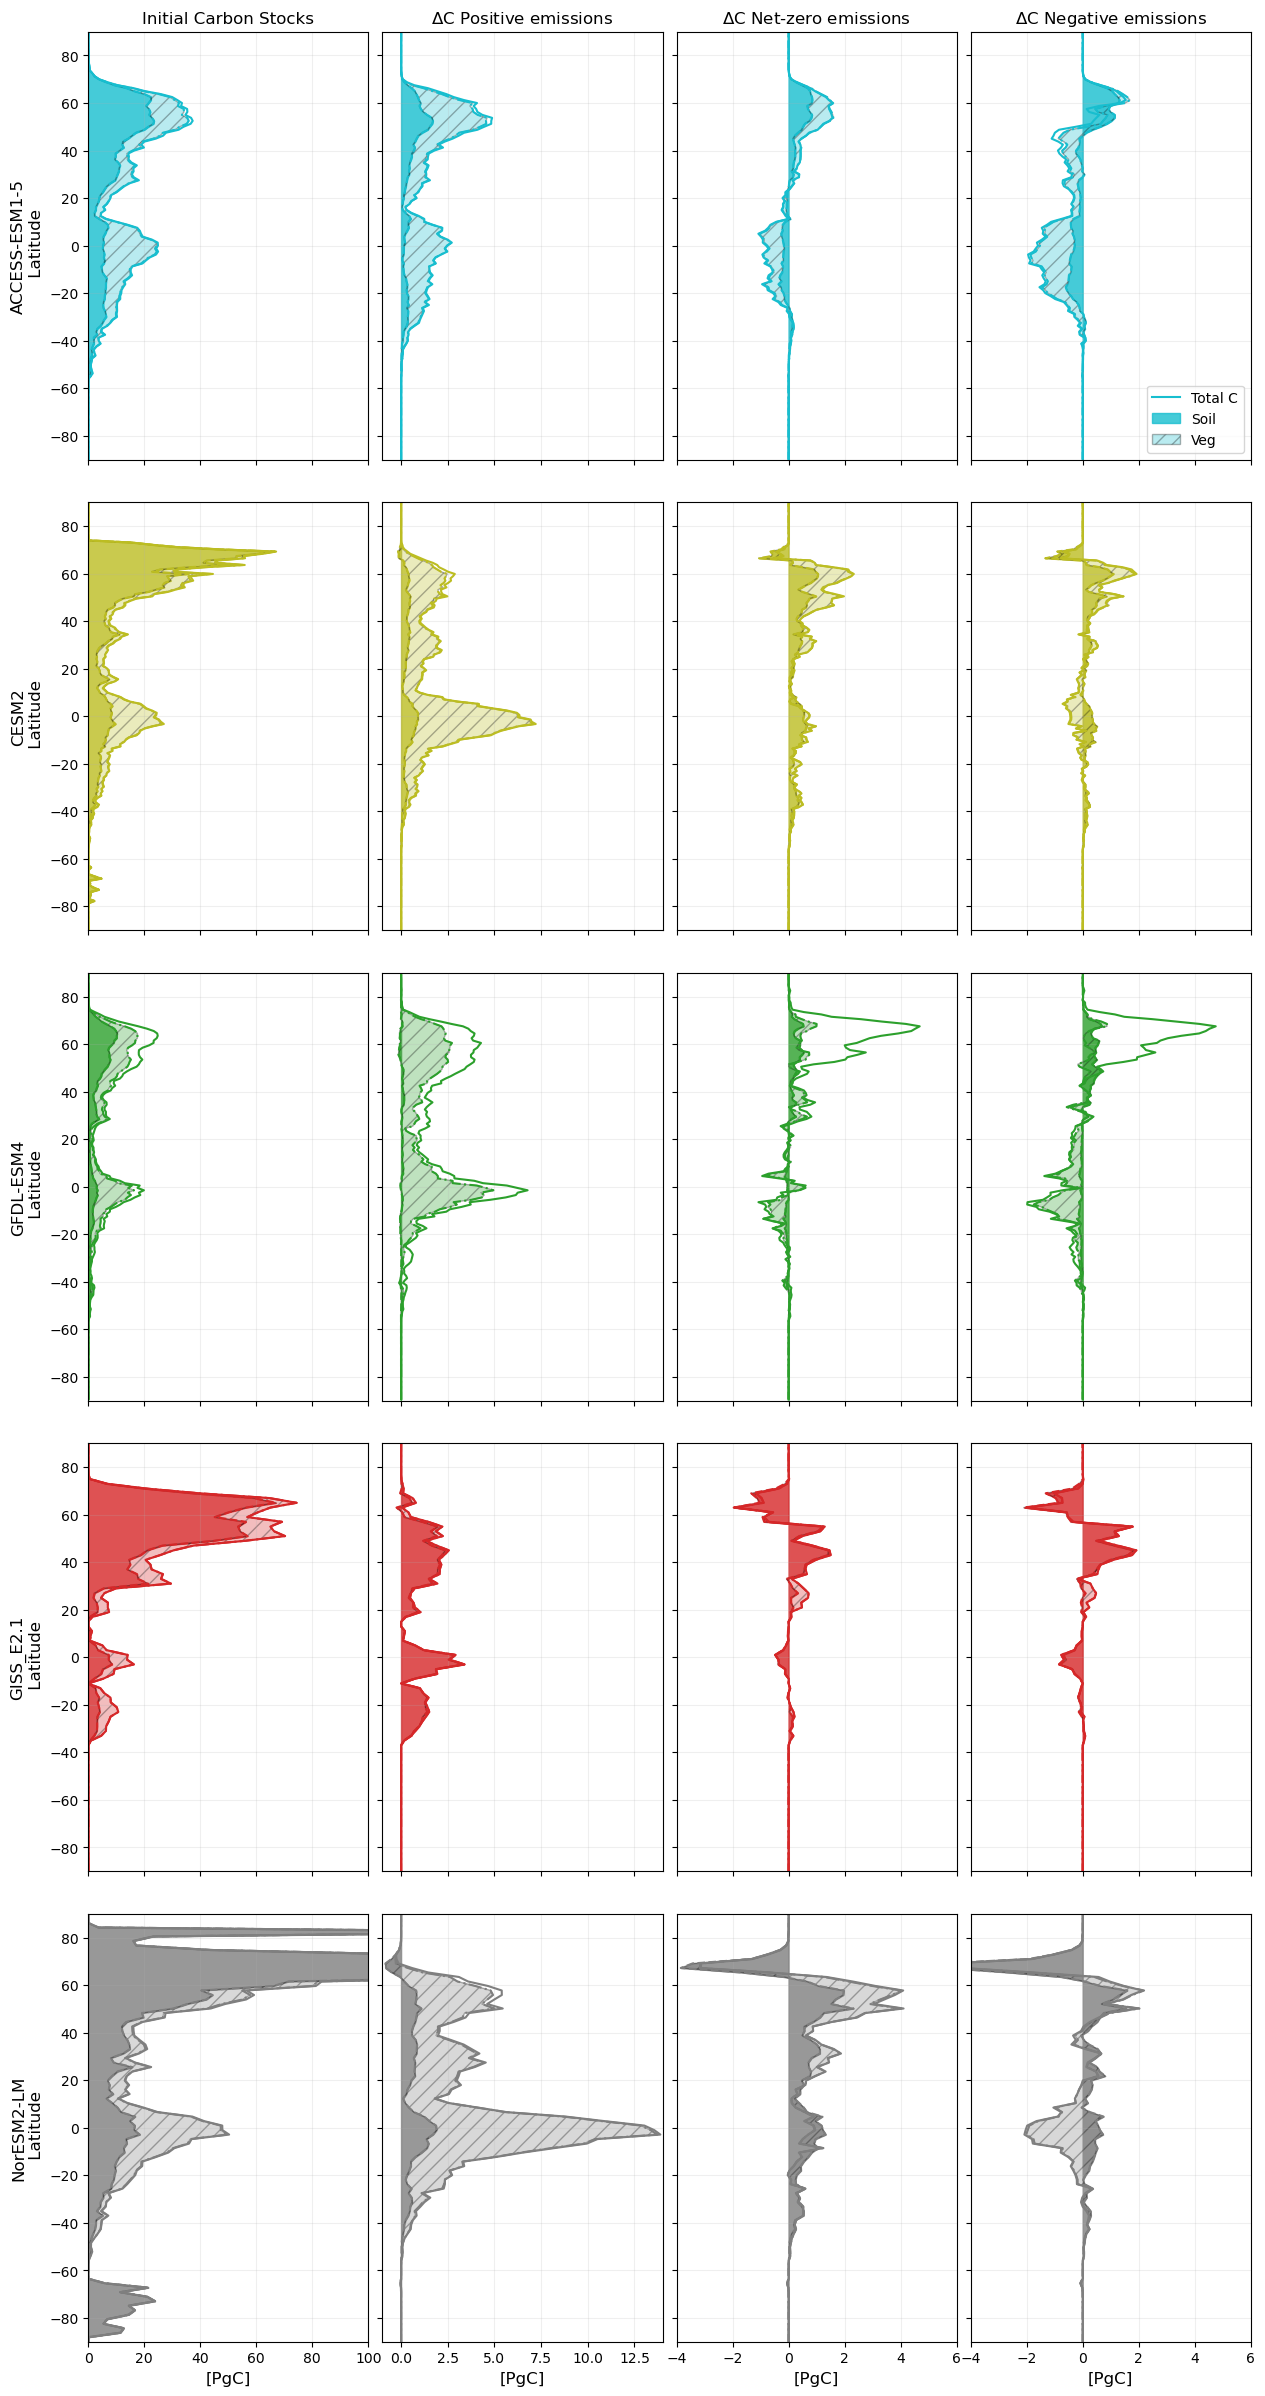

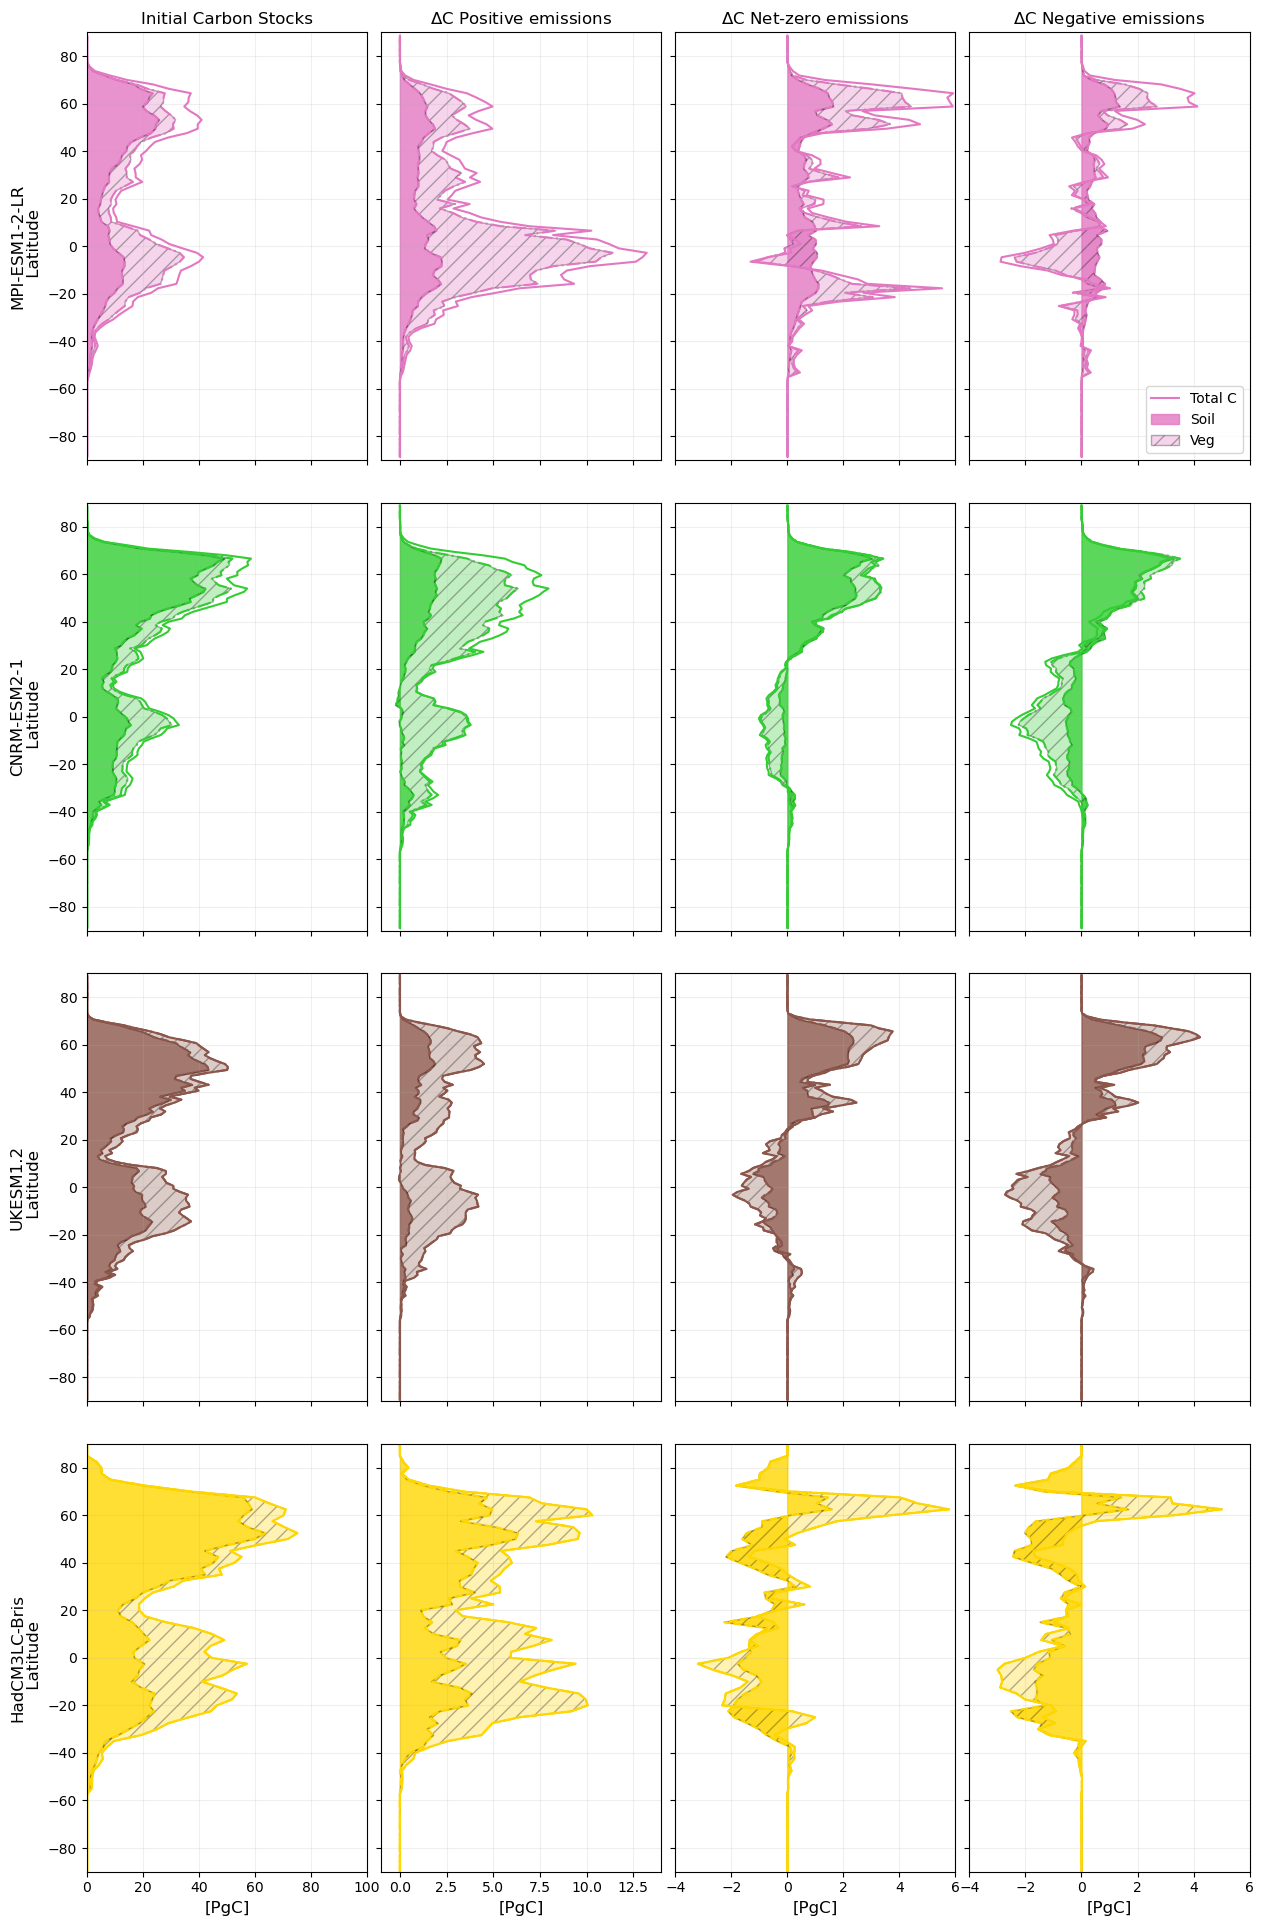

done saving file


In [177]:
# first column original units (kgC/m2)
# total carbon units (sum of all carbon, not per m2)

phasename=['InitialC','EmissionsPhase','NetZero','CumulativeZero']

num_rows=5 #len(modellist)
num_cols=4
fig0, axes0 = plt.subplots(num_rows,num_cols,figsize=(3.75 * num_cols, num_rows * 6 )) # initial C
fig1, axes1 = plt.subplots(num_rows,num_cols,figsize=(3.75 * num_cols, num_rows * 6 )) # emissions phase
# fig2, axes2 = plt.subplots(num_rows,num_cols,figsize=(3.75 * num_cols, num_rows * 6 )) # net zero
# fig3, axes3 = plt.subplots(num_rows,num_cols,figsize=(3.75 * num_cols, num_rows * 6 )) # cumulative zero

# axes=axes0.flatten()
# axes1=axes1.flatten()
# axes2=axes2.flatten()
# axes3=axes3.flatten()


unitconvert=PgperKg
# zonal mean shaded plot, one plot for each model

# loop over models
for m in range(len(modellist)):
    model=modellist[m]
    print('Plotting ' +model)

    mcolor=modelcolors[m]

    # load data from pre-processed output
    ds_all=xr.open_dataset('processed_output/zonal_means_timepoints_' +model +'.nc')
    lat=ds_all.lat
    
    ###----------------------Plot-------------------------###

    # to use, refer to one index in axs: ax = axs[row, column]

    if m<num_rows:
        axes=axes0
        mi=m
    else:
        axes=axes1
        mi=m-num_rows
    #--------------------------Second row is total carbon units (PgC)
    #---First column is flat10 climatology
    #--- first figure is the climatology, or average of first 10 years 
    ax = axes[mi,0]


    ax.plot(ds_all.dsften_cTot_PgC,lat, linestyle='-',color=mcolor,label='Total C')
    ax.plot(ds_all.dsften_cSoil_PgC,lat, linestyle='--',color=mcolor,label='_nolabel_')
    ax.plot((ds_all.dsften_cVeg_PgC+ds_all.dsften_cSoil_PgC),lat, linestyle='-.',color=mcolor,label='_nolabel_')

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, ds_all.dsften_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,ds_all.dsften_cSoil_PgC,ds_all.dsften_cSoil_PgC+ds_all.dsften_cVeg_PgC,alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    ax.set_ylim([-90, 90])
    ax.grid(True,alpha=0.2, zorder=0)
    ax.set_ylabel(model +'\n Latitude',fontsize=12)
    ax.set_title('')
    ax.set_xlim([0, 100])

    #--- Second figure is end of flat10 emissions phase
    ax = axes[mi,1]
  

    # plot lines soil, veg + soil, total-litter, total
    (ds_all.dslten0_cTot_PgC-ds_all.dsften_cTot_PgC).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total C')
    (ds_all.dslten0_cSoil_PgC-ds_all.dsften_cSoil_PgC).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((ds_all.dslten0_cVeg_PgC+ds_all.dslten0_cSoil_PgC)-(ds_all.dsften_cVeg_PgC+ds_all.dsften_cSoil_PgC)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, ds_all.dslten0_cSoil_PgC-ds_all.dsften_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,ds_all.dslten0_cSoil_PgC-ds_all.dsften_cSoil_PgC,
                           (ds_all.dslten0_cSoil_PgC-ds_all.dsften_cSoil_PgC)+
                           (ds_all.dslten0_cVeg_PgC-ds_all.dsften_cVeg_PgC),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    ax.set_ylim([-90, 90])
    ax.grid(True,alpha=0.2, zorder=0)
    ax.set_title('')
    ax.set_yticklabels([])
    ax.set_ylabel('')

    ax.set_xlim([-1, 14])
    # ax.annotate(subplotlabelnames[m],
    #                      xy=(0.8, 1), xycoords='axes fraction',
    #                      xytext=(+0.5, -0.5), textcoords='offset fontsize',
    #                      fontsize='large', verticalalignment='top')


    #--- Third figure is end of flat10zec phase
    ax = axes[mi,2] 

    # plot lines soil, veg + soil, total-litter, total
    (ds_all.dslten1_cTot_PgC-ds_all.dslten0_cTot_PgC).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total C')
    (ds_all.dslten1_cSoil_PgC-ds_all.dslten0_cSoil_PgC).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((ds_all.dslten1_cVeg_PgC+ds_all.dslten1_cSoil_PgC)-(ds_all.dslten0_cVeg_PgC+ds_all.dslten0_cSoil_PgC)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, ds_all.dslten1_cSoil_PgC-ds_all.dslten0_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,ds_all.dslten1_cSoil_PgC-ds_all.dslten0_cSoil_PgC,
                           (ds_all.dslten1_cSoil_PgC-ds_all.dslten0_cSoil_PgC)+
                           (ds_all.dslten1_cVeg_PgC-ds_all.dslten0_cVeg_PgC),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    ax.set_ylim([-90, 90])
    ax.grid(True,alpha=0.2, zorder=0)
    ax.set_title('')
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.set_xlim([-4, 6])
    # ax.annotate(subplotlabelnames[m],
    #                      xy=(0, 1), xycoords='axes fraction',
    #                      xytext=(+0.5, -0.5), textcoords='offset fontsize',
    #                      fontsize='large', verticalalignment='top')
    
        
    #--- Fourth figure is end of flat10cdr phase

    ax = axes[mi,3] 

    # plot lines soil, veg + soil, total-litter, total
    (ds_all.dslten2_cTot_PgC-ds_all.dsften_cTot_PgC).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total C')
    (ds_all.dslten2_cSoil_PgC-ds_all.dsften_cSoil_PgC).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((ds_all.dslten2_cVeg_PgC+ds_all.dslten2_cSoil_PgC)-
     (ds_all.dsften_cVeg_PgC+ds_all.dsften_cSoil_PgC)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)
    
    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, ds_all.dslten2_cSoil_PgC-ds_all.dsften_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,ds_all.dslten2_cSoil_PgC-ds_all.dsften_cSoil_PgC,
                           (ds_all.dslten2_cSoil_PgC-ds_all.dsften_cSoil_PgC)+
                           (ds_all.dslten2_cVeg_PgC-ds_all.dsften_cVeg_PgC),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    ax.set_ylim([-90, 90])
    ax.grid(True,alpha=0.2, zorder=0)
    ax.set_title('')
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.set_xlim([-4, 6])


    # ax.annotate(subplotlabelnames[m],
    #                      xy=(0, 1), xycoords='axes fraction',
    #                      xytext=(+0.5, -0.5), textcoords='offset fontsize',
    #                      fontsize='large', verticalalignment='top')

    if m ==0 or m==5: ax.legend(loc='lower right')

for air in range(num_rows):
    for aic in range(num_cols):
        if air==num_rows-1: # it's the last row
            axes0[air,aic].set_xlabel('[PgC]',fontsize=12)
            axes1[air,aic].set_visible(False)
        elif air==num_rows-2:
            axes0[air,aic].xaxis.set_tick_params(labelcolor='none')
            axes1[air,aic].set_xlabel('[PgC]',fontsize=12)
        else:
            axes0[air,aic].xaxis.set_tick_params(labelcolor='none')
            axes1[air,aic].xaxis.set_tick_params(labelcolor='none')
        if aic>0:
            axes0[air,aic].yaxis.set_tick_params(labelcolor='none')
            axes1[air,aic].yaxis.set_tick_params(labelcolor='none')

    
        # axes[air,aic].annotate(subplotlabelnames[(air+aic)+air*(nc-1)],
        #              xy=(0, 1), xycoords='axes fraction',
        #              xytext=(+0.5, -0.5), textcoords='offset fontsize',
        #              fontsize='large', verticalalignment='top')

# set title over whole plot
yh=0.92

axes0[0,0].set_title('Initial Carbon Stocks',fontsize=12)
axes0[0,1].set_title('$\Delta$C Positive emissions',fontsize=12)
axes0[0,2].set_title('$\Delta$C Net-zero emissions',fontsize=12)
axes0[0,3].set_title('$\Delta$C Negative emissions',fontsize=12)

axes1[0,0].set_title('Initial Carbon Stocks',fontsize=12)
axes1[0,1].set_title('$\Delta$C Positive emissions',fontsize=12)
axes1[0,2].set_title('$\Delta$C Net-zero emissions',fontsize=12)
axes1[0,3].set_title('$\Delta$C Negative emissions',fontsize=12)

fig0.subplots_adjust(wspace=0.05, hspace=0.1)
fig1.subplots_adjust(wspace=0.05, hspace=0.1)



# save the plot
fig0.savefig('figures/' +'Cdelta_zonal_lineplot_allmodels_allphases0.png', bbox_inches='tight', dpi=400)
plt.show(fig0)
plt.close(fig0)

fig1.savefig('figures/' +'Cdelta_zonal_lineplot_allmodels_allphases1.png', bbox_inches='tight', dpi=400)
plt.show(fig1)
plt.close(fig1)

print('done saving file')


## alternative zonal mean plot

Plotting ACCESS-ESM1-5
Plotting CESM2
Plotting GFDL-ESM4
Plotting GISS_E2.1
Plotting NorESM2-LM
Plotting MPI-ESM1-2-LR
Plotting CNRM-ESM2-1
Plotting UKESM1.2
Plotting HadCM3LC-Bris


FileNotFoundError: [Errno 2] No such file or directory: '/glade/work/aswann/datasets/cSoil_fx_HWSD2_19600101-20220101.nc'

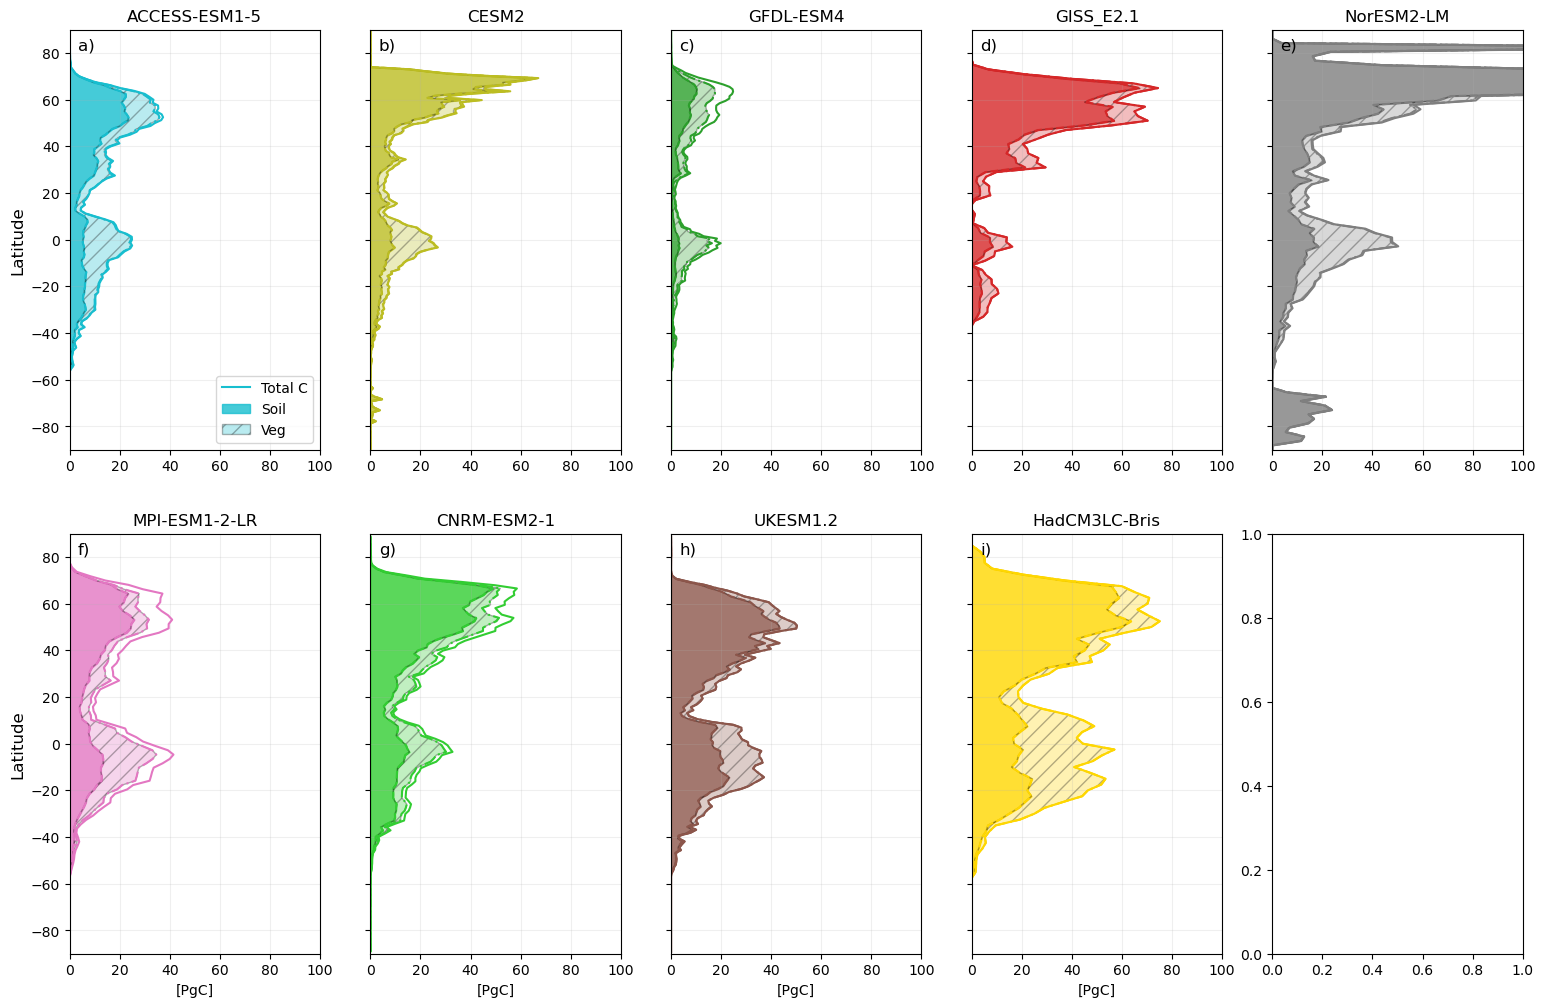

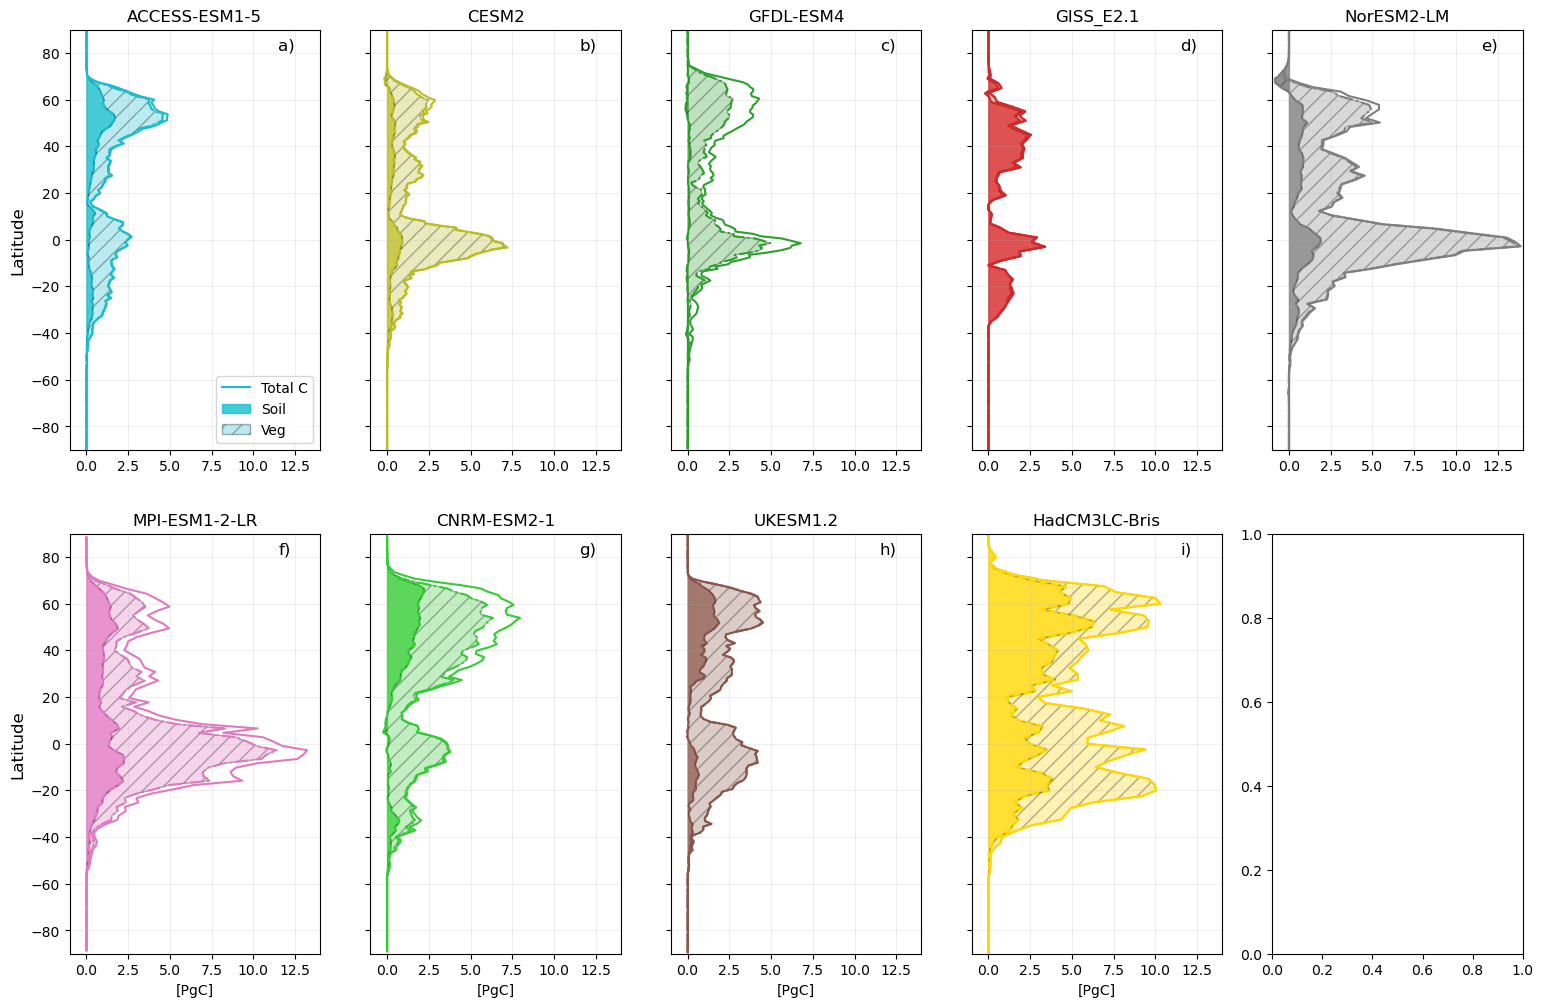

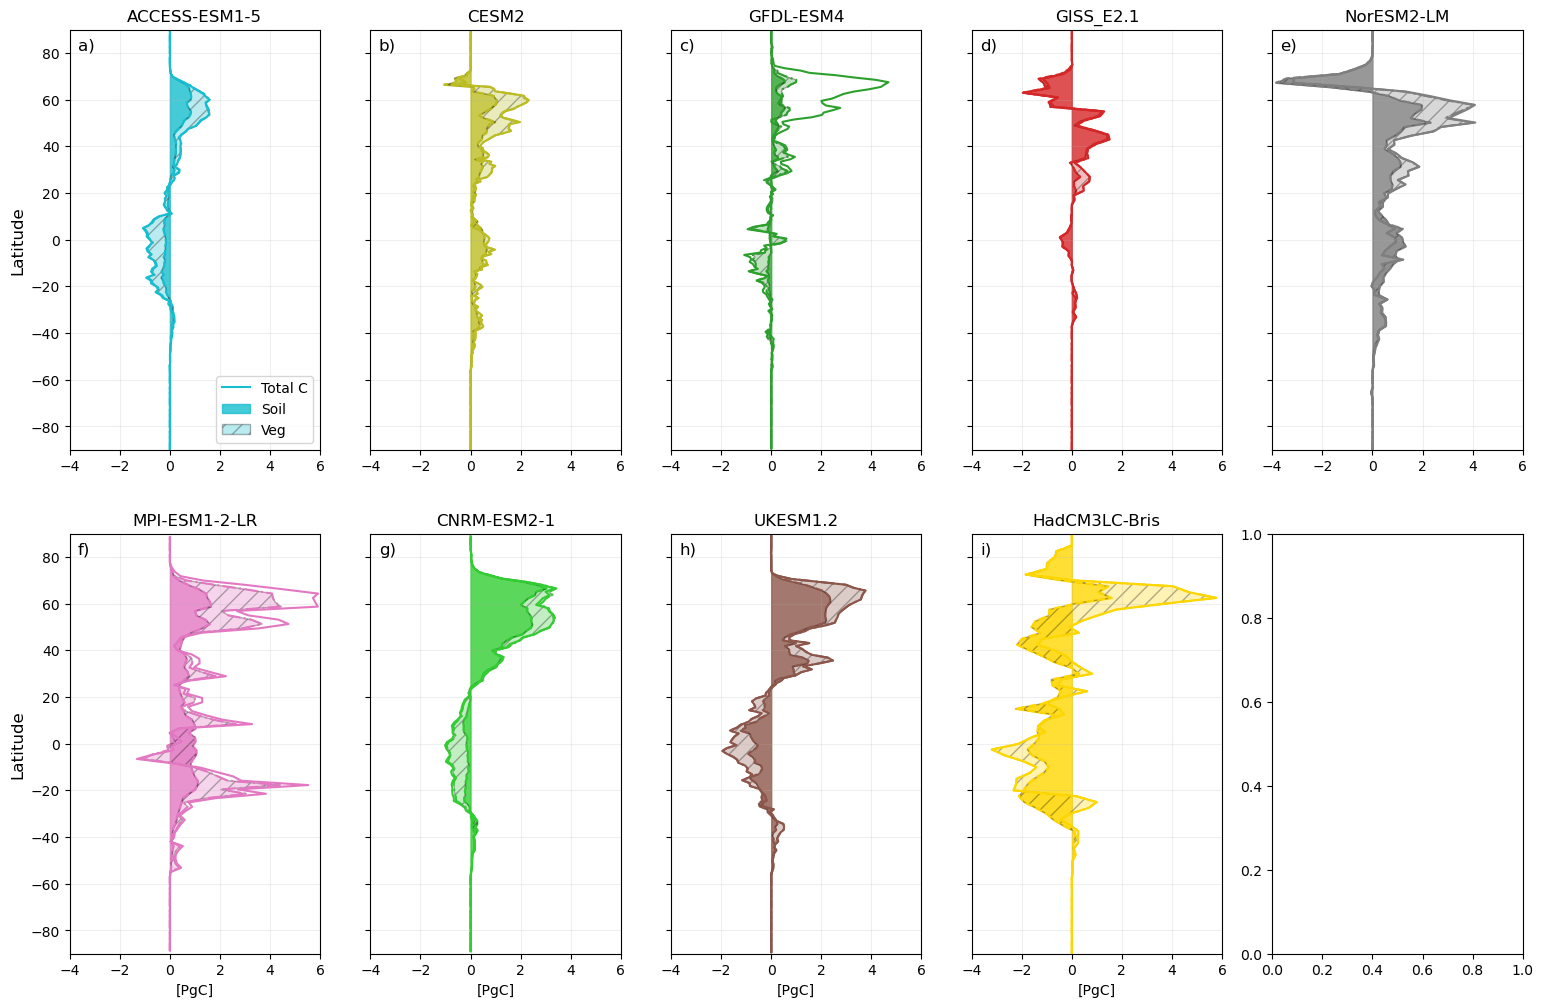

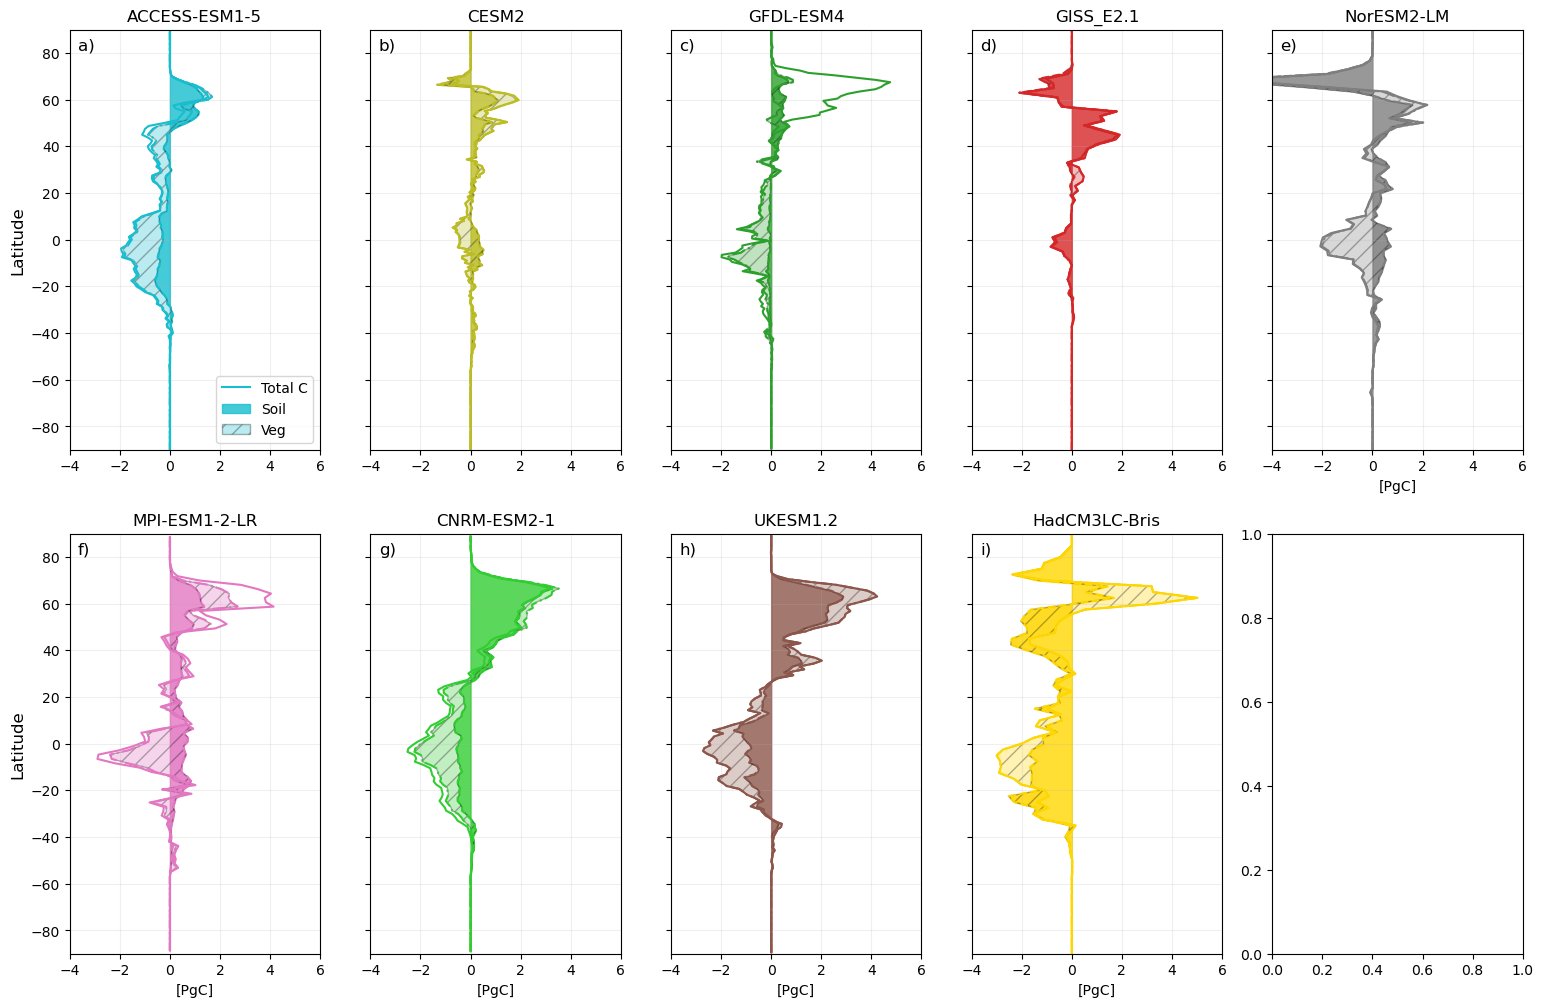

In [176]:
# first column original units (kgC/m2)
# total carbon units (sum of all carbon, not per m2)

phasename=['InitialC','EmissionsPhase','NetZero','CumulativeZero']

num_rows=2
num_cols=5
fig0, axes0 = plt.subplots(num_rows,num_cols,figsize=(3.75 * num_cols, num_rows * 6 )) # initial C
fig1, axes1 = plt.subplots(num_rows,num_cols,figsize=(3.75 * num_cols, num_rows * 6 )) # emissions phase
fig2, axes2 = plt.subplots(num_rows,num_cols,figsize=(3.75 * num_cols, num_rows * 6 )) # net zero
fig3, axes3 = plt.subplots(num_rows,num_cols,figsize=(3.75 * num_cols, num_rows * 6 )) # cumulative zero

axes0=axes0.flatten()
axes1=axes1.flatten()
axes2=axes2.flatten()
axes3=axes3.flatten()


unitconvert=PgperKg
# zonal mean shaded plot, one plot for each model

# loop over models
for m in range(len(modellist)):
    model=modellist[m]
    print('Plotting ' +model)

    mcolor=modelcolors[m]

    # load data from pre-processed output
    ds_all=xr.open_dataset('processed_output/zonal_means_timepoints_' +model +'.nc')
    lat=ds_all.lat

    ###----------------------Plot-------------------------###

    # to use, refer to one index in axs: ax = axs[row, column]


    #--------------------------Second row is total carbon units (PgC)
    #---First column is flat10 climatology
    #--- first figure is the climatology, or average of first 10 years 
    ax = axes0[m]

    ax.plot(ds_all.dsften_cTot_PgC,lat, linestyle='-',color=mcolor,label='Total C')
    ax.plot(ds_all.dsften_cSoil_PgC,lat, linestyle='--',color=mcolor,label='_nolabel_')
    ax.plot((ds_all.dsften_cVeg_PgC+ds_all.dsften_cSoil_PgC),lat, linestyle='-.',color=mcolor,label='_nolabel_')

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, ds_all.dsften_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,ds_all.dsften_cSoil_PgC,ds_all.dsften_cSoil_PgC+ds_all.dsften_cVeg_PgC,alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    ax.set_ylim([-90, 90])
    ax.grid(True,alpha=0.2, zorder=0)
    ax.set_ylabel('Latitude',fontsize=12)
    ax.set_title(model)
    if (m!=0 and m!=num_cols): #remove y ticks for plots that are not on the left hand edge of the plot
        ax.set_yticklabels([])
        ax.set_ylabel('')
    ax.set_xlim([0, 100])

    if m>num_cols-1:
        ax.set_xlabel('[PgC]')
    ax.annotate(subplotlabelnames[m],
                         xy=(0, 1), xycoords='axes fraction',
                         xytext=(+0.5, -0.5), textcoords='offset fontsize',
                         fontsize='large', verticalalignment='top')
    
    #--- Second figure is end of flat10 emissions phase
    ax = axes1[m]
    #dsdelta=(dslten0.mean(dim='time')-dsften.mean(dim='time')).mean(dim='lon') #last 10 years of flat10 minus first ten years of flat10-zec
    #.plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor)
    

    # plot lines soil, veg + soil, total-litter, total
    (ds_all.dslten0_cTot_PgC-ds_all.dsften_cTot_PgC).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total C')
    (ds_all.dslten0_cSoil_PgC-ds_all.dsften_cSoil_PgC).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((ds_all.dslten0_cVeg_PgC+ds_all.dslten0_cSoil_PgC)-
     (ds_all.dsften_cVeg_PgC+ds_all.dsften_cSoil_PgC)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, ds_all.dslten0_cSoil_PgC-ds_all.dsften_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,ds_all.dslten0_cSoil_PgC-ds_all.dsften_cSoil_PgC,
                           (ds_all.dslten0_cSoil_PgC-ds_all.dsften_cSoil_PgC)+
                           (ds_all.dslten0_cVeg_PgC-ds_all.dsften_cVeg_PgC),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    ax.set_ylim([-90, 90])
    ax.grid(True,alpha=0.2, zorder=0)
    ax.set_ylabel('Latitude',fontsize=12)
    ax.set_title(model)
    if (m!=0 and m!=num_cols): #remove y ticks for plots that are not on the left hand edge of the plot
        ax.set_yticklabels([])
        ax.set_ylabel('')

    ax.set_xlim([-1, 14])
    ax.annotate(subplotlabelnames[m],
                         xy=(0.8, 1), xycoords='axes fraction',
                         xytext=(+0.5, -0.5), textcoords='offset fontsize',
                         fontsize='large', verticalalignment='top')

    if m>num_cols-1:
        ax.set_xlabel('[PgC]')

    #--- Third figure is end of flat10zec phase
    ax = axes2[m] 
    #dsdelta=dslten1.mean(dim='time')-dslten0.mean(dim='time') #last 10 years of flat10-zec minus last 10 years of flat10
    #fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor) 

    # plot lines soil, veg + soil, total-litter, total
    (ds_all.dslten1_cTot_PgC-ds_all.dslten0_cTot_PgC).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total C')
    (ds_all.dslten1_cSoil_PgC-ds_all.dslten0_cSoil_PgC).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((ds_all.dslten1_cVeg_PgC+ds_all.dslten1_cSoil_PgC)-
     (ds_all.dslten0_cVeg_PgC+ds_all.dslten0_cSoil_PgC)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, ds_all.dslten1_cSoil_PgC-ds_all.dslten0_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,ds_all.dslten1_cSoil_PgC-ds_all.dslten0_cSoil_PgC,
                           (ds_all.dslten1_cSoil_PgC-ds_all.dslten0_cSoil_PgC)+
                           (ds_all.dslten1_cVeg_PgC-ds_all.dslten0_cVeg_PgC),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    ax.set_ylim([-90, 90])
    ax.grid(True,alpha=0.2, zorder=0)
    ax.set_ylabel('Latitude',fontsize=12)
    ax.set_title(model)
    if (m!=0 and m!=num_cols): #remove y ticks for plots that are not on the left hand edge of the plot
        ax.set_yticklabels([])
        ax.set_ylabel('')
    ax.set_xlim([-4, 6])
    ax.annotate(subplotlabelnames[m],
                         xy=(0, 1), xycoords='axes fraction',
                         xytext=(+0.5, -0.5), textcoords='offset fontsize',
                         fontsize='large', verticalalignment='top')
    
    if m>num_cols-1:
        ax.set_xlabel('[PgC]')
        
    #--- Fourth figure is end of flat10cdr phase

    ax = axes3[m] 

    #dsdelta=dslten2.mean(dim='time')-dsften.mean(dim='time') #last 10 years of flat10-cdr minus first ten years of flat10
    #fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor) 


    # plot lines soil, veg + soil, total-litter, total
    (ds_all.dslten2_cTot_PgC-ds_all.dsften_cTot_PgC).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total C')
    (ds_all.dslten2_cSoil_PgC-ds_all.dsften_cSoil_PgC).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((ds_all.dslten2_cVeg_PgC+ds_all.dslten2_cSoil_PgC)-
     (ds_all.dsften_cVeg_PgC+ds_all.dsften_cSoil_PgC)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)
    
    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, ds_all.dslten2_cSoil_PgC-ds_all.dsften_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,ds_all.dslten2_cSoil_PgC-ds_all.dsften_cSoil_PgC,
                           (ds_all.dslten2_cSoil_PgC-ds_all.dsften_cSoil_PgC)+
                           (ds_all.dslten2_cVeg_PgC-ds_all.dsften_cVeg_PgC),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    ax.set_ylim([-90, 90])
    ax.grid(True,alpha=0.2, zorder=0)
    ax.set_ylabel('Latitude',fontsize=12)
    ax.set_title(model)
    if (m!=0 and m!=num_cols): #remove y ticks for plots that are not on the left hand edge of the plot
        ax.set_yticklabels([])
        ax.set_ylabel('')
    ax.set_xlim([-4, 6])

    if m>num_cols-2:
        ax.set_xlabel('[PgC]')

    ax.annotate(subplotlabelnames[m],
                         xy=(0, 1), xycoords='axes fraction',
                         xytext=(+0.5, -0.5), textcoords='offset fontsize',
                         fontsize='large', verticalalignment='top')




# add gridlines
#axes0[m].grid(True,alpha=0.2, zorder=0)

# add legend
axes0[0].legend(loc='lower right')
axes1[0].legend(loc='lower right')
axes2[0].legend(loc='lower right')
axes3[0].legend(loc='lower right')

# add a zonal profile of observed c pools on the ititial C plot (axes0)
ax=axes0[9]
cSoil, cVeg, cSoil_zonal, cVeg_zonal=load_observations(1) #load the data
lat=cVeg_zonal.lat
fg = ax.fill_betweenx(lat,0, cSoil_zonal.values,alpha=0.8,color=soilcolor,label='Soil')
fg2 = ax.fill_betweenx(lat,cSoil_zonal.values, cSoil_zonal.values+cVeg_zonal.values,color=vegcolor,label='Veg',hatch='//',edgecolor='grey')

ax.set_title('Observations')
ax.set_ylim([-90, 90])
ax.set_yticklabels([])
ax.set_ylabel('')
ax.grid(True,alpha=0.2, zorder=0)
ax.set_xlim([0,100])
ax.set_xlabel('[PgC]')
ax.legend(loc='lower right')
ax.annotate(subplotlabelnames[9],
                         xy=(0, 1), xycoords='axes fraction',
                         xytext=(+0.5, -0.5), textcoords='offset fontsize',
                         fontsize='large', verticalalignment='top')

# remve the empty plot in the last slot - if we add a 10th model will need to disable this!
# axes0[9].set_visible(False) 
axes1[9].set_visible(False)
axes2[9].set_visible(False) 
axes3[9].set_visible(False)

# set title over whole plot
yh=0.92
fig0.suptitle('Initial Carbon Stocks (beginning of flat10)',y=yh)
fig1.suptitle('Carbon gained during emissions phase (end of flat10 - beginning of flat10)',y=yh)
fig2.suptitle('Carbon change after net-zero (end of flat10zec - end of flat10)',y=yh)
fig3.suptitle('Carbon change at cumulative zero emissions (end of flat10cdr - beginning of flat10)',y=yh)

# save the plot
fig0.savefig('figures/' +'Cdelta_zonal_lineplot_allmodels_' +phasename[0] +'.png', bbox_inches='tight', dpi=400)
plt.show(fig0)
plt.close(fig0)

fig1.savefig('figures/' +'Cdelta_zonal_lineplot_allmodels_' +phasename[1] +'.png', bbox_inches='tight', dpi=400)
plt.show(fig1)
plt.close(fig1)

fig2.savefig('figures/' +'Cdelta_zonal_lineplot_allmodels_' +phasename[2] +'.png', bbox_inches='tight', dpi=400)
plt.show(fig2)
plt.close(fig2)

fig3.savefig('figures/' +'Cdelta_zonal_lineplot_allmodels_' +phasename[3] +'.png', bbox_inches='tight', dpi=400)
plt.show(fig3)
plt.close(fig3)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
# plt.close()


# Print tables to screen

In [20]:
veg_stock_delta_cTot

Total C [PgC]  Highlat C [PgC]  Midlat C [PgC]  \
ACCESS-ESM1-5                1516.352349       184.338892      838.177310   
CESM2                        1986.902417       630.593939      777.709766   
GFDL-ESM4                     978.098317       230.451760      445.063401   
GISS_E2.1                    1163.288648       332.538927      713.494341   
NorESM2-LM                   3119.341255      1806.262359      734.550412   
MPI-ESM1-2-LR                1389.555906       188.469727      652.131706   
CNRM-ESM2-1                  2168.320090       415.901820     1196.082594   
UKESM1.2                     2333.319736       192.972645     1310.106786   
HadCM3LC-Bris                1991.894128       345.710120      919.691252   
Multi-model Mean             1849.674761       480.804466      843.000841   
Multi-model Standard Dev.     594.990981       462.881852      240.071023   
ACCESS-ESM1-5                 163.560520        17.797008       94.726388   
CESM2                         255.320292        15.551415      101.574175   
GFDL-ESM4                     251.912973        41.764039      104.191535   
GISS_E2.1                      67.145613         2.326604       41.534112   
NorESM2-LM                    255.266525         8.129868      100.931492   
MPI-ESM1-2-LR                 308.973581        19.040005      103.756841   
CNRM-ESM2-1                   307.524435        46.245560      197.414742   
UKESM1.2                      237.380177        26.628075      120.192629   
HadCM3LC-Bris                 309.863139        43.309534      138.355971   
Multi-model Mean              239.660806        24.532456      111.408654   
Multi-model Standard Dev.      71.087918        14.295782       36.984102   
ACCESS-ESM1-5                   3.884319         7.614382       16.361841   
CESM2                          59.441879         6.102607       45.320504   
GFDL-ESM4                      52.324488        40.171940       25.506479   
GISS_E2.1                       1.794584        -6.047519       10.340827   
NorESM2-LM                     42.192423        -6.280496       42.912637   
MPI-ESM1-2-LR                  88.985254        25.465009       44.423074   
CNRM-ESM2-1                    32.791288        20.159662       33.067048   
UKESM1.2                       29.001556        26.090179       42.323139   
HadCM3LC-Bris                 -23.234555        11.036995       -2.195113   
Multi-model Mean               31.909026        13.812529       28.673382   
Multi-model Standard Dev.      30.464082        13.875663       15.440550   
ACCESS-ESM1-5                 -47.748300         9.230984      -16.506002   
CESM2                          23.223889         4.390821       27.278604   
GFDL-ESM4                      30.579354        44.038969       16.342343   
GISS_E2.1                       5.170800        -5.178790       14.012352   
NorESM2-LM                    -10.036545       -12.794998       16.710976   
MPI-ESM1-2-LR                  25.608161        19.900320       17.475350   
CNRM-ESM2-1                   -10.268686        21.759292       11.515348   
UKESM1.2                       12.989701        28.036307       38.671478   
HadCM3LC-Bris                 -31.040414         8.750407      -11.936785   
Multi-model Mean               -0.169115        13.125924       12.618185   
Multi-model Standard Dev.      24.031275        15.543287       15.499158   

                           Lowlat C [PgC]                         Group  
ACCESS-ESM1-5                  493.836147        Initial Carbon Content  
CESM2                          578.598712        Initial Carbon Content  
GFDL-ESM4                      302.583156        Initial Carbon Content  
GISS_E2.1                      117.255380        Initial Carbon Content  
NorESM2-LM                     578.528484        Initial Carbon Content  
MPI-ESM1-2-LR                  548.954473        Initial Carbon Content  
CNRM-ESM2-1                    556.335677  

In [21]:
veg_stock_delta_global

Total C [PgC]  % Vegetation    % Litter  \
ACCESS-ESM1-5                1516.352349     42.735800    2.866672   
CESM2                        1986.902417     27.863300    1.645594   
GFDL-ESM4                     978.098317     44.805041   21.223944   
GISS_E2.1                    1163.288648     25.032698         NaN   
NorESM2-LM                   3119.341255     17.322195    0.961071   
MPI-ESM1-2-LR                1389.555906     30.943824   19.735226   
CNRM-ESM2-1                  2168.320090     23.581081    9.882205   
UKESM1.2                     2333.319736     25.384135         NaN   
HadCM3LC-Bris                1991.894128     32.460142         NaN   
Multi-model Mean             1849.674761     30.014246    9.385785   
Multi-model Standard Dev.     594.990981      8.005037    7.754119   
ACCESS-ESM1-5                 163.560520     70.107798    3.947695   
CESM2                         255.320292     78.929950    4.091723   
GFDL-ESM4                     251.912973     65.464061   33.388078   
GISS_E2.1                      67.145613      8.874185         NaN   
NorESM2-LM                    255.266525     80.733010    3.838655   
MPI-ESM1-2-LR                 308.973581     54.615487   20.623354   
CNRM-ESM2-1                   307.524435     62.499894   16.146966   
UKESM1.2                      237.380177     74.769065         NaN   
HadCM3LC-Bris                 309.863139     53.048837         NaN   
Multi-model Mean              239.660806     61.004699   13.672745   
Multi-model Standard Dev.      71.087918     19.561888   10.185487   
ACCESS-ESM1-5                   3.884319    -93.092637  -47.001906   
CESM2                          59.441879     38.541453   -0.332948   
GFDL-ESM4                      52.324488     -8.088624   92.227780   
GISS_E2.1                       1.794584    241.704742         NaN   
NorESM2-LM                     42.192423     26.175304    2.342641   
MPI-ESM1-2-LR                  88.985254     26.591204   25.446119   
CNRM-ESM2-1                    32.791288    -31.958781  -20.638081   
UKESM1.2                       29.001556     11.311497         NaN   
HadCM3LC-Bris                 -23.234555   -123.609861         NaN   
Multi-model Mean               31.909026      9.730477    8.673934   
Multi-model Standard Dev.      30.464082     92.524106   40.254111   
ACCESS-ESM1-5                 -47.748300     87.830507   18.342908   
CESM2                          23.223889      1.680434   -5.163426   
GFDL-ESM4                      30.579354   -112.966187  174.302254   
GISS_E2.1                       5.170800     87.129104         NaN   
NorESM2-LM                    -10.036545    165.942408    7.690726   
MPI-ESM1-2-LR                  25.608161    -68.672644   43.570386   
CNRM-ESM2-1                   -10.268686    276.643322  182.128171   
UKESM1.2                       12.989701    -78.163563         NaN   
HadCM3LC-Bris                 -31.040414    -63.433410         NaN   
Multi-model Mean               -0.169115     32.887774   70.145170   
Multi-model Standard Dev.      24.031275    117.155065   72.062003   

                               % Soil                         Group  
ACCESS-ESM1-5               54.397528        Initial Carbon Content  
CESM2                       70.491106        Initial Carbon Content  
GFDL-ESM4                   33.971015        Initial Carbon Content  
GISS_E2.1                   74.967302        Initial Carbon Content  
NorESM2-LM                  81.716734        Initial Carbon Content  
MPI-ESM1-2-LR               49.320950        Initial Carbon Content  
CNRM-ESM2-1                 66.536713        Initial Carbon Content  
UKESM1.2                    74.615865        Initial Carbon Content  
HadCM3LC-Bris               67.539858        Initial Carbon Content  
Multi-model Mean            63.728563        Initial Carbon Content  
Multi-model Standard Dev.   13.478575        Initial Carbon Content  
ACCESS-ESM1-5               25.94450

In [22]:
veg_stock_delta_highlat

Total C [PgC]  % Vegetation   % Litter      % Soil  \
ACCESS-ESM1-5                 184.338892     20.607097   2.692756   76.700147   
CESM2                         630.593939      6.236867   0.981657   92.781476   
GFDL-ESM4                     230.451760     29.534442  28.178593   42.286965   
GISS_E2.1                     332.538927     10.700768        NaN   89.299232   
NorESM2-LM                   1806.262359      1.617229   0.247036   98.135735   
MPI-ESM1-2-LR                 188.469727     10.066686  24.945033   64.988281   
CNRM-ESM2-1                   415.901820      7.199867  11.255587   81.544546   
UKESM1.2                      192.972645     16.426020        NaN   83.573980   
HadCM3LC-Bris                 345.710120     11.434437        NaN   88.565563   
Multi-model Mean              480.804466     12.647046  11.383444   79.763992   
Multi-model Standard Dev.     462.881852      7.531022  10.513630   15.248892   
ACCESS-ESM1-5                  17.797008     57.905937   8.920425   33.173638   
CESM2                          15.551415     79.838032  15.958850    4.203117   
GFDL-ESM4                      41.764039     63.742816  36.722192   -0.465008   
GISS_E2.1                       2.326604     59.890866        NaN   40.109134   
NorESM2-LM                      8.129868    117.324384  22.504454  -39.828838   
MPI-ESM1-2-LR                  19.040005     40.844404  28.150948   31.004648   
CNRM-ESM2-1                    46.245560     32.538934  31.757449   35.703617   
UKESM1.2                       26.628075     60.326932        NaN   39.673068   
HadCM3LC-Bris                  43.309534     42.862506        NaN   57.137494   
Multi-model Mean               24.532456     61.697201  24.002387   22.301208   
Multi-model Standard Dev.      14.295782     22.554293   8.730512   26.290757   
ACCESS-ESM1-5                   7.614382     31.540999  -2.233670   70.692671   
CESM2                           6.102607    111.712628  -0.861029  -10.851599   
GFDL-ESM4                      40.171940      5.503190  84.185872   10.310938   
GISS_E2.1                      -6.047519    -11.675622        NaN  111.675622   
NorESM2-LM                     -6.280496    -68.030185  -3.600006  171.630191   
MPI-ESM1-2-LR                  25.465009     41.870177  32.358104   25.771719   
CNRM-ESM2-1                    20.159662     12.630817  -6.783825   94.153008   
UKESM1.2                       26.090179     41.520194        NaN   58.479806   
HadCM3LC-Bris                  11.036995    122.743487        NaN  -22.743487   
Multi-model Mean               13.812529     31.979521  17.177574   56.568763   
Multi-model Standard Dev.      13.875663     52.694961  30.304654   56.405490   
ACCESS-ESM1-5                   9.230984     20.381647  -7.195067   86.813421   
CESM2                           4.390821    128.526940  13.203839  -41.730779   
GFDL-ESM4                      44.038969     -1.722876  89.377629   12.345247   
GISS_E2.1                      -5.178790    -22.519685        NaN  122.519685   
NorESM2-LM                    -12.794998    -27.789976  -4.259783  132.049759   
MPI-ESM1-2-LR                  19.900320     28.151850  41.427615   30.420534   
CNRM-ESM2-1                    21.759292     10.481471 -11.987908  101.506437   
UKESM1.2                       28.036307     35.391172        NaN   64.608828   
HadCM3LC-Bris                   8.750407    131.082644        NaN  -31.082644   
Multi-model Mean               13.125924     33.553687  20.094387   53.050054   
Multi-model Standard Dev.      15.543287     52.365930  33.101289   57.375315   

                                                  Group  
ACCESS-ESM1-5                    Initial Carbon Content  
CESM2                            Initial Carbon Content  
GFDL-ESM4                        Initial Carbon Content  
GISS_E2.1                        Initial Carbon Content  
NorESM2-LM                       Initial Carbon Content  
MPI-ESM1-2-LR                    

In [23]:
veg_stock_delta_midlat

Total C [PgC]  % Vegetation    % Litter  \
ACCESS-ESM1-5                 838.177310     35.530834    3.300950   
CESM2                         777.709766     25.951498    2.294533   
GFDL-ESM4                     445.063401     41.518427   20.095501   
GISS_E2.1                     713.494341     27.646419         NaN   
NorESM2-LM                    734.550412     26.545418    2.272770   
MPI-ESM1-2-LR                 652.131706     23.631823   20.449623   
CNRM-ESM2-1                  1196.082594     22.100563    9.936215   
UKESM1.2                     1310.106786     17.441561         NaN   
HadCM3LC-Bris                 919.691252     21.217792         NaN   
Multi-model Mean              843.000841     26.842704    9.724932   
Multi-model Standard Dev.     240.071023      6.672389    7.315594   
ACCESS-ESM1-5                  94.726388     64.182470    4.459401   
CESM2                         101.574175     71.715305    5.685859   
GFDL-ESM4                     104.191535     57.811366   40.287038   
GISS_E2.1                      41.534112      9.568681         NaN   
NorESM2-LM                    100.931492     72.289730    5.718308   
MPI-ESM1-2-LR                 103.756841     43.833945   23.439209   
CNRM-ESM2-1                   197.414742     59.314444   16.666846   
UKESM1.2                      120.192629     66.765459         NaN   
HadCM3LC-Bris                 138.355971     45.537525         NaN   
Multi-model Mean              111.408654     54.557658   16.042777   
Multi-model Standard Dev.      36.984102     17.618346   11.897874   
ACCESS-ESM1-5                  16.361841     46.531125   -4.076921   
CESM2                          45.320504     44.860218    0.300364   
GFDL-ESM4                      25.506479      7.338009   66.576316   
GISS_E2.1                      10.340827     34.446514         NaN   
NorESM2-LM                     42.912637     36.592354    1.911794   
MPI-ESM1-2-LR                  44.423074     37.712120   20.499372   
CNRM-ESM2-1                    33.067048      4.726131  -11.511428   
UKESM1.2                       42.323139     28.267059         NaN   
HadCM3LC-Bris                  -2.195113  -1025.361877         NaN   
Multi-model Mean               28.673382    -87.209817   12.283250   
Multi-model Standard Dev.      15.440550    314.947229   24.202244   
ACCESS-ESM1-5                 -16.506002    102.341961   36.202494   
CESM2                          27.278604     39.058068   -3.927682   
GFDL-ESM4                      16.342343    -67.649475  109.342863   
GISS_E2.1                      14.012352     24.056282         NaN   
NorESM2-LM                     16.710976      8.111077   -4.032698   
MPI-ESM1-2-LR                  17.475350      1.778462   24.512267   
CNRM-ESM2-1                    11.515348    -49.103260  -87.087548   
UKESM1.2                       38.671478     24.473780         NaN   
HadCM3LC-Bris                 -11.936785   -139.898035         NaN   
Multi-model Mean               12.618185     -6.314571   12.501616   
Multi-model Standard Dev.      15.499158     62.806218   54.176328   

                                % Soil                         Group  
ACCESS-ESM1-5                61.168216        Initial Carbon Content  
CESM2                        71.753969        Initial Carbon Content  
GFDL-ESM4                    38.386071        Initial Carbon Content  
GISS_E2.1                    72.353581        Initial Carbon Content  
NorESM2-LM                   71.181811        Initial Carbon Content  
MPI-ESM1-2-LR                55.918554        Initial Carbon Content  
CNRM-ESM2-1                  67.963222        Initial Carbon Content  
UKESM1.2                     82.558439        Initial Carbon Content  
HadCM3LC-Bris                78.782208        Initial Carbon Content  
Multi-model Mean             66.674008        Initial Carbon Content  
Multi-model Standard Dev.    11.938050        Initial Carbon Content  
ACCESS-ESM1-5           

In [24]:
veg_stock_delta_troplat

Total C [PgC]  % Vegetation   % Litter      % Soil  \
ACCESS-ESM1-5                 493.836147     63.224822   2.194500   34.580679   
CESM2                         578.598712     54.002874   1.496938   44.500188   
GFDL-ESM4                     302.583156     61.269567  17.586984   21.143449   
GISS_E2.1                     117.255380     49.773995        NaN   50.226005   
NorESM2-LM                    578.528484     54.645105   1.524960   43.829935   
MPI-ESM1-2-LR                 548.954473     46.797773  17.097900   36.104327   
CNRM-ESM2-1                   556.335677     39.010254   8.739385   52.250362   
UKESM1.2                      830.240305     39.999532        NaN   60.000468   
HadCM3LC-Bris                 726.492755     56.697535        NaN   43.302465   
Multi-model Mean              525.869454     51.713495   8.106778   42.881986   
Multi-model Standard Dev.     189.143899      7.674768   6.470594   10.128425   
ACCESS-ESM1-5                  51.037124     85.360254   1.263928   13.375818   
CESM2                         138.194702     84.130581   1.584582   14.284837   
GFDL-ESM4                     105.957399     73.667661  25.289925    1.042414   
GISS_E2.1                      23.284897      2.537852        NaN   97.462148   
NorESM2-LM                    146.205165     84.527060   1.503124   13.969816   
MPI-ESM1-2-LR                 186.176735     62.032420  18.284235   19.683346   
CNRM-ESM2-1                    63.864133     94.042107   3.236000    2.721893   
UKESM1.2                       90.559473     89.638195        NaN   10.361805   
HadCM3LC-Bris                 128.197635     64.596634        NaN   35.403366   
Multi-model Mean              103.719696     71.170307   8.526966   23.145049   
Multi-model Standard Dev.      46.264186     25.010544   8.900066   26.481031   
ACCESS-ESM1-5                 -20.091903     67.843330   4.920214   27.236457   
CESM2                           8.018767    -52.857201  -3.510413  156.367614   
GFDL-ESM4                     -13.353931     62.264339  19.040523   18.695138   
GISS_E2.1                      -2.498724     -2.779589        NaN  102.779589   
NorESM2-LM                      5.560282   -160.628199  -1.044590  261.672789   
MPI-ESM1-2-LR                  19.097171    -19.651481  27.736297   91.915184   
CNRM-ESM2-1                   -20.435422     71.389854   7.797280   20.812867   
UKESM1.2                      -39.411762     49.517425        NaN   50.482575   
HadCM3LC-Bris                 -32.076436     22.866775        NaN   77.133225   
Multi-model Mean              -10.576884      4.218361   9.156552   89.677271   
Multi-model Standard Dev.      17.438841     67.364678  10.192499   70.413025   
ACCESS-ESM1-5                 -40.473282     66.528911   5.234729   28.236359   
CESM2                          -8.445536    188.355383   8.377068  -96.732452   
GFDL-ESM4                     -29.801957     76.270445  13.185936   10.543619   
GISS_E2.1                      -3.662762      0.868925        NaN   99.131075   
NorESM2-LM                    -13.952523    154.567397   4.608623  -59.176019   
MPI-ESM1-2-LR                 -11.767508    199.693102  11.644416 -111.337518   
CNRM-ESM2-1                   -43.543326     57.491969  13.929232   28.578799   
UKESM1.2                      -53.718085     54.990723        NaN   45.009277   
HadCM3LC-Bris                 -27.854036     30.442984        NaN   69.557016   
Multi-model Mean              -25.913224     92.134427   9.496667    1.534462   
Multi-model Standard Dev.      15.678577     63.519686   3.405495   66.068155   

                                                  Group  
ACCESS-ESM1-5                    Initial Carbon Content  
CESM2                            Initial Carbon Content  
GFDL-ESM4                        Initial Carbon Content  
GISS_E2.1                        Initial Carbon Content  
NorESM2-LM                       Initial Carbon Content  
MPI-ESM1-2-LR                    

In [25]:
leadlagpeak_global_cdr

cTot       cVeg    cLitter       cSoil  \
ACCESS-ESM1-5             -11.000000   4.000000 -99.000000   57.000000   
CESM2                      18.000000  13.000000  20.000000   44.000000   
GFDL-ESM4                  17.000000   7.000000  42.000000  126.000000   
GISS_E2.1                   8.000000  25.000000        NaN    8.000000   
NorESM2-LM                 19.000000   9.000000  -1.000000   40.000000   
MPI-ESM1-2-LR              18.000000  12.000000  24.000000   27.000000   
CNRM-ESM2-1                21.000000  21.000000   7.000000   47.000000   
UKESM1.2                   10.000000  10.000000        NaN   27.000000   
HadCM3LC-Bris              -3.000000   5.000000        NaN   -9.000000   
Multi-model Mean            8.818182   9.636364  -0.875000   33.363636   
Multi-model Standard Dev.   9.967251   6.923243  39.661086   34.396378   

                                 tas        co2  
ACCESS-ESM1-5               5.000000 -10.000000  
CESM2                     -12.000000 -22.000000  
GFDL-ESM4                 -27.000000 -18.000000  
GISS_E2.1                   3.000000 -16.000000  
NorESM2-LM                -28.000000 -22.000000  
MPI-ESM1-2-LR               2.000000 -26.000000  
CNRM-ESM2-1                -2.000000 -23.000000  
UKESM1.2                  -18.000000 -10.000000  
HadCM3LC-Bris               7.000000 -16.000000  
Multi-model Mean           -6.363636 -14.818182  
Multi-model Standard Dev.  11.993817   7.097350

In [26]:
# it's possible to print these dataframes to latex tables like this:

df=leadlagpeak_global_cdr
# print(df.style.Styler.to_latex(float_format="{:.1f}".format)) #'tables/leadlagpeak_global_cdr.tex'

print(df.to_latex(float_format="{:.1f}".format))#,'tables/leadlagpeak_global_cdr.tex')

\begin{tabular}{lrrrrrr}
\toprule
 & cTot & cVeg & cLitter & cSoil & tas & co2 \\
\midrule
ACCESS-ESM1-5 & -11.0 & 4.0 & -99.0 & 57.0 & 5.0 & -10.0 \\
CESM2 & 18.0 & 13.0 & 20.0 & 44.0 & -12.0 & -22.0 \\
GFDL-ESM4 & 17.0 & 7.0 & 42.0 & 126.0 & -27.0 & -18.0 \\
GISS_E2.1 & 8.0 & 25.0 & NaN & 8.0 & 3.0 & -16.0 \\
NorESM2-LM & 19.0 & 9.0 & -1.0 & 40.0 & -28.0 & -22.0 \\
MPI-ESM1-2-LR & 18.0 & 12.0 & 24.0 & 27.0 & 2.0 & -26.0 \\
CNRM-ESM2-1 & 21.0 & 21.0 & 7.0 & 47.0 & -2.0 & -23.0 \\
UKESM1.2 & 10.0 & 10.0 & NaN & 27.0 & -18.0 & -10.0 \\
HadCM3LC-Bris & -3.0 & 5.0 & NaN & -9.0 & 7.0 & -16.0 \\
Multi-model Mean & 8.8 & 9.6 & -0.9 & 33.4 & -6.4 & -14.8 \\
Multi-model Standard Dev. & 10.0 & 6.9 & 39.7 & 34.4 & 12.0 & 7.1 \\
\bottomrule
\end{tabular}



In [27]:
df=veg_stock_delta_cTot

print(df.to_latex(float_format="{:.0f}".format))


\begin{tabular}{lrrrrl}
\toprule
 & Total C [PgC] & Highlat C [PgC] & Midlat C [PgC] & Lowlat C [PgC] & Group \\
\midrule
ACCESS-ESM1-5 & 1516 & 184 & 838 & 494 & Initial Carbon Content \\
CESM2 & 1987 & 631 & 778 & 579 & Initial Carbon Content \\
GFDL-ESM4 & 978 & 230 & 445 & 303 & Initial Carbon Content \\
GISS_E2.1 & 1163 & 333 & 713 & 117 & Initial Carbon Content \\
NorESM2-LM & 3119 & 1806 & 735 & 579 & Initial Carbon Content \\
MPI-ESM1-2-LR & 1390 & 188 & 652 & 549 & Initial Carbon Content \\
CNRM-ESM2-1 & 2168 & 416 & 1196 & 556 & Initial Carbon Content \\
UKESM1.2 & 2333 & 193 & 1310 & 830 & Initial Carbon Content \\
HadCM3LC-Bris & 1992 & 346 & 920 & 726 & Initial Carbon Content \\
Multi-model Mean & 1850 & 481 & 843 & 526 & Initial Carbon Content \\
Multi-model Standard Dev. & 595 & 463 & 240 & 189 & Initial Carbon Content \\
ACCESS-ESM1-5 & 164 & 18 & 95 & 51 & Delta after Emissions Phase \\
CESM2 & 255 & 16 & 102 & 138 & Delta after Emissions Phase \\
GFDL-ESM4 & 252 & 42 

In [28]:
df=veg_stock_delta_global

print(df.to_latex(float_format="{:.0f}".format))


\begin{tabular}{lrrrrl}
\toprule
 & Total C [PgC] & % Vegetation & % Litter & % Soil & Group \\
\midrule
ACCESS-ESM1-5 & 1516 & 43 & 3 & 54 & Initial Carbon Content \\
CESM2 & 1987 & 28 & 2 & 70 & Initial Carbon Content \\
GFDL-ESM4 & 978 & 45 & 21 & 34 & Initial Carbon Content \\
GISS_E2.1 & 1163 & 25 & NaN & 75 & Initial Carbon Content \\
NorESM2-LM & 3119 & 17 & 1 & 82 & Initial Carbon Content \\
MPI-ESM1-2-LR & 1390 & 31 & 20 & 49 & Initial Carbon Content \\
CNRM-ESM2-1 & 2168 & 24 & 10 & 67 & Initial Carbon Content \\
UKESM1.2 & 2333 & 25 & NaN & 75 & Initial Carbon Content \\
HadCM3LC-Bris & 1992 & 32 & NaN & 68 & Initial Carbon Content \\
Multi-model Mean & 1850 & 30 & 9 & 64 & Initial Carbon Content \\
Multi-model Standard Dev. & 595 & 8 & 8 & 13 & Initial Carbon Content \\
ACCESS-ESM1-5 & 164 & 70 & 4 & 26 & Delta after Emissions Phase \\
CESM2 & 255 & 79 & 4 & 17 & Delta after Emissions Phase \\
GFDL-ESM4 & 252 & 65 & 33 & 1 & Delta after Emissions Phase \\
GISS_E2.1 & 67 & 9

In [29]:
df

Total C [PgC]  % Vegetation    % Litter  \
ACCESS-ESM1-5                1516.352349     42.735800    2.866672   
CESM2                        1986.902417     27.863300    1.645594   
GFDL-ESM4                     978.098317     44.805041   21.223944   
GISS_E2.1                    1163.288648     25.032698         NaN   
NorESM2-LM                   3119.341255     17.322195    0.961071   
MPI-ESM1-2-LR                1389.555906     30.943824   19.735226   
CNRM-ESM2-1                  2168.320090     23.581081    9.882205   
UKESM1.2                     2333.319736     25.384135         NaN   
HadCM3LC-Bris                1991.894128     32.460142         NaN   
Multi-model Mean             1849.674761     30.014246    9.385785   
Multi-model Standard Dev.     594.990981      8.005037    7.754119   
ACCESS-ESM1-5                 163.560520     70.107798    3.947695   
CESM2                         255.320292     78.929950    4.091723   
GFDL-ESM4                     251.912973     65.464061   33.388078   
GISS_E2.1                      67.145613      8.874185         NaN   
NorESM2-LM                    255.266525     80.733010    3.838655   
MPI-ESM1-2-LR                 308.973581     54.615487   20.623354   
CNRM-ESM2-1                   307.524435     62.499894   16.146966   
UKESM1.2                      237.380177     74.769065         NaN   
HadCM3LC-Bris                 309.863139     53.048837         NaN   
Multi-model Mean              239.660806     61.004699   13.672745   
Multi-model Standard Dev.      71.087918     19.561888   10.185487   
ACCESS-ESM1-5                   3.884319    -93.092637  -47.001906   
CESM2                          59.441879     38.541453   -0.332948   
GFDL-ESM4                      52.324488     -8.088624   92.227780   
GISS_E2.1                       1.794584    241.704742         NaN   
NorESM2-LM                     42.192423     26.175304    2.342641   
MPI-ESM1-2-LR                  88.985254     26.591204   25.446119   
CNRM-ESM2-1                    32.791288    -31.958781  -20.638081   
UKESM1.2                       29.001556     11.311497         NaN   
HadCM3LC-Bris                 -23.234555   -123.609861         NaN   
Multi-model Mean               31.909026      9.730477    8.673934   
Multi-model Standard Dev.      30.464082     92.524106   40.254111   
ACCESS-ESM1-5                 -47.748300     87.830507   18.342908   
CESM2                          23.223889      1.680434   -5.163426   
GFDL-ESM4                      30.579354   -112.966187  174.302254   
GISS_E2.1                       5.170800     87.129104         NaN   
NorESM2-LM                    -10.036545    165.942408    7.690726   
MPI-ESM1-2-LR                  25.608161    -68.672644   43.570386   
CNRM-ESM2-1                   -10.268686    276.643322  182.128171   
UKESM1.2                       12.989701    -78.163563         NaN   
HadCM3LC-Bris                 -31.040414    -63.433410         NaN   
Multi-model Mean               -0.169115     32.887774   70.145170   
Multi-model Standard Dev.      24.031275    117.155065   72.062003   

                               % Soil                         Group  
ACCESS-ESM1-5               54.397528        Initial Carbon Content  
CESM2                       70.491106        Initial Carbon Content  
GFDL-ESM4                   33.971015        Initial Carbon Content  
GISS_E2.1                   74.967302        Initial Carbon Content  
NorESM2-LM                  81.716734        Initial Carbon Content  
MPI-ESM1-2-LR               49.320950        Initial Carbon Content  
CNRM-ESM2-1                 66.536713        Initial Carbon Content  
UKESM1.2                    74.615865        Initial Carbon Content  
HadCM3LC-Bris               67.539858        Initial Carbon Content  
Multi-model Mean            63.728563        Initial Carbon Content  
Multi-model Standard Dev.   13.478575        Initial Carbon Content  
ACCESS-ESM1-5               25.94450

In [30]:
# it's possible to print these dataframes to latex tables like this:

#leadlagpeak_global_cdr

taulist=['cTot', 'cVeg', 'cLitter','cSoil','tas','co2']#tauV','tauL','tauS','Q10','rmse']

formatters = {
    'cTot': lambda x: f"{x:.0f}",  # Format to 2 decimal places
    'cVeg': lambda x: f"{x:.0f}", # 
    'cLitter': lambda x: f"{x:.0f}",   # 
    'cSoil': lambda x: f"{x:.0f}",   # 
    'tas': lambda x: f"{x:.0f}",   # 
    'co2': lambda x: f"{x:.0f}",  # Format to 2 decimal places

}

df=pd.concat([leadlagpeak_global_cdr[taulist[0]], leadlagpeak_global_cdr[taulist[1]],leadlagpeak_global_cdr[taulist[2]], leadlagpeak_global_cdr[taulist[3]],leadlagpeak_global_cdr[taulist[4]],leadlagpeak_global_cdr[taulist[5]],
             leadlagpeak_highlat_cdr[taulist[0]], leadlagpeak_highlat_cdr[taulist[1]],leadlagpeak_highlat_cdr[taulist[2]], leadlagpeak_highlat_cdr[taulist[3]],leadlagpeak_highlat_cdr[taulist[4]],
             leadlagpeak_midlat_cdr[taulist[0]], leadlagpeak_midlat_cdr[taulist[1]],leadlagpeak_midlat_cdr[taulist[2]], leadlagpeak_midlat_cdr[taulist[3]],leadlagpeak_midlat_cdr[taulist[4]],
             leadlagpeak_troplat_cdr[taulist[0]], leadlagpeak_troplat_cdr[taulist[1]],leadlagpeak_troplat_cdr[taulist[2]], leadlagpeak_troplat_cdr[taulist[3]], leadlagpeak_troplat_cdr[taulist[4]]
             ],axis=1)

# print(df.to_latex(float_format="{:.1f}".format))#,'tables/leadlagpeak_global_cdr.tex')
print(df.to_latex(formatters=formatters, escape=False))#,'tables/leadlagpeak_global_cdr.tex')

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrr}
\toprule
 & cTot & cVeg & cLitter & cSoil & tas & co2 & cTot & cVeg & cLitter & cSoil & tas & cTot & cVeg & cLitter & cSoil & tas & cTot & cVeg & cLitter & cSoil & tas \\
\midrule
ACCESS-ESM1-5 & -11 & 4 & -99 & 57 & 5 & -10 & 38 & 11 & -103 & 97 & 7 & 11 & 11 & -105 & 51 & 5 & -40 & -37 & -99 & -75 & 15 \\
CESM2 & 18 & 13 & 20 & 44 & -12 & -22 & 13 & 11 & 18 & -61 & -12 & 18 & 14 & 21 & 49 & -12 & 13 & 13 & 20 & 35 & -2 \\
GFDL-ESM4 & 17 & 7 & 42 & 126 & -27 & -18 & 48 & 15 & 76 & 146 & 1 & 20 & 16 & 35 & 126 & -23 & -10 & 7 & -9 & -84 & 5 \\
GISS_E2.1 & 8 & 25 & NaN & 8 & 3 & -16 & -31 & 28 & NaN & -89 & -21 & 17 & 25 & NaN & 8 & -7 & 2 & 12 & NaN & -9 & 4 \\
NorESM2-LM & 19 & 9 & -1 & 40 & -28 & -22 & -23 & 5 & 47 & -149 & -30 & 30 & 8 & 19 & 52 & -28 & 13 & 13 & 14 & 39 & -11 \\
MPI-ESM1-2-LR & 18 & 12 & 24 & 27 & 2 & -26 & 57 & 57 & 78 & 53 & 9 & 27 & 29 & 27 & 27 & -13 & 13 & 6 & 20 & 24 & 14 \\
CNRM-ESM2-1 & 21 & 21 & 7 & 47 & -2 & -23 & 2

In [31]:
# Define formatting functions for specific columns
formatters = {
    'tauV': lambda x: f"{x:.1f}",  # Format to 2 decimal places
    'tauL': lambda x: f"{x:.0f}", # 
    'tauS': lambda x: f"{x:.0f}",   # 
    'Q10': lambda x: f"{x:.1f}",   # 
    'rmse': lambda x: f"{x:.1f}",   # 
    'tauV': lambda x: f"{x:.1f}",  # Format to 2 decimal places
    'tauL': lambda x: f"{x:.0f}", # 
    'tauS': lambda x: f"{x:.0f}",   # 
    'Q10': lambda x: f"{x:.1f}",   # 
    'rmse': lambda x: f"{x:.1f}",   # 
    'tauV': lambda x: f"{x:.1f}",  # Format to 2 decimal places
    'tauL': lambda x: f"{x:.0f}", # 
    'tauS': lambda x: f"{x:.0f}",   # 
    'Q10': lambda x: f"{x:.1f}",   # 
    'rmse': lambda x: f"{x:.1f}",   #
    'tauV': lambda x: f"{x:.1f}",  # Format to 2 decimal places
    'tauL': lambda x: f"{x:.0f}", # 
    'tauS': lambda x: f"{x:.0f}",   # 
    'Q10': lambda x: f"{x:.1f}",   # 
    'rmse': lambda x: f"{x:.1f}"   # 
}


print(df.to_latex(formatters=formatters, escape=False))#,'tables/leadlagpeak_global_cdr.tex')

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrr}
\toprule
 & cTot & cVeg & cLitter & cSoil & tas & co2 & cTot & cVeg & cLitter & cSoil & tas & cTot & cVeg & cLitter & cSoil & tas & cTot & cVeg & cLitter & cSoil & tas \\
\midrule
ACCESS-ESM1-5 & -11.000000 & 4.000000 & -99.000000 & 57.000000 & 5.000000 & -10.000000 & 38.000000 & 11.000000 & -103.000000 & 97.000000 & 7.000000 & 11.000000 & 11.000000 & -105.000000 & 51.000000 & 5.000000 & -40.000000 & -37.000000 & -99.000000 & -75.000000 & 15.000000 \\
CESM2 & 18.000000 & 13.000000 & 20.000000 & 44.000000 & -12.000000 & -22.000000 & 13.000000 & 11.000000 & 18.000000 & -61.000000 & -12.000000 & 18.000000 & 14.000000 & 21.000000 & 49.000000 & -12.000000 & 13.000000 & 13.000000 & 20.000000 & 35.000000 & -2.000000 \\
GFDL-ESM4 & 17.000000 & 7.000000 & 42.000000 & 126.000000 & -27.000000 & -18.000000 & 48.000000 & 15.000000 & 76.000000 & 146.000000 & 1.000000 & 20.000000 & 16.000000 & 35.000000 & 126.000000 & -23.000000 & -10.000000 & 7.000000 & -9.000